# Time series for the restoration of TA-DIC, pHT, Ωar, and calcification for three levels of TA additions 
## CDRefficiency = 100%

Figures 8 and S9 in the manuscript by Hanna et al 2025, expanded to include all species for calcification analysis


In [1]:
# # Run the following commands to install PyOAE and delta_method for the first time
# !pip install git+https://github.com/gjpelletier/PyOAE.git
# !pip install git+https://github.com/gjpelletier/delta_method.git

# # Run the following commands to upgrade PyOAE and delta_method to the latest versions
# !pip install git+https://github.com/gjpelletier/PyOAE.git --upgrade
# !pip install git+https://github.com/gjpelletier/delta_method.git --upgrade

In [2]:
# from PyOAE import pco2_fass, pco2_tnorm, nnn, sine_fit, etamax, fCO2_to_pCO2
from PyOAE import nnn, etamax
from delta_method import delta_method
import PyCO2SYS as pyco2
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import scipy.optimize as opt
import multiprocessing
import pandas as pd

In [3]:
# matlab-style tic toc timer
def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )
    return

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

In [4]:
# import Hanna's Table 1 to get the regression coefficients Slope, Intercept, and Exp.
# df = pd.read_excel('3 new species for Greg_v20250428.xlsx', sheet_name='Sheet1', engine='openpyxl')   # double precision paramter values
df = pd.read_excel('T1.xlsx', sheet_name='Sheet1', engine='openpyxl')   # double precision paramter values
print(df.head())

   Group                                   Reference                 Species  \
0  Algae                         Meyer et al. (2015)        Halimeda opuntia   
1  Algae                        Comeau et al. (2013)  Hydrolithon reinboldii   
2  Algae                       Johnson et al. (2021)        Lithophyllum sp.   
3  Algae              Briggs-Carpenter et al. (2019)      Porolithon onkodes   
4  Algae  Comeau et al. (2018), Comeau et al. (2019)       Sporolithon durum   

    Region                            Rate unit     Response     Slope  \
0  Coastal  Calc rate [mmol/m**2/hr] (compiled)       linear  0.000171   
1  Coastal     Calc rate [mmol/g/hr] (compiled)       linear  0.000007   
2  Coastal     Calc rate [mmol/g/hr] (compiled)  exponential -0.395864   
3  Coastal  Calc rate [mmol/m**2/hr] (compiled)       linear  0.001660   
4  Coastal  Calc rate [mmol/m**2/hr] (compiled)       linear  0.000902   

   Intercept  Exponent       p-value    R2    RMSE     Temp_range    Sal_r

In [5]:
# read netcdf file of OceanSODA-ETHZ v2023 data
ds = xr.open_dataset("OceanSODA_ETHZ_for_PyOAE.nc",chunks={"lon":60})
# ds = xr.open_dataset("OceanSODA_ETHZ_v2023_b20250106_lon360.nc",chunks={"lon":60})
# Convert ds to dictionary of numpy arrays for computations
ds_dict = {var: ds[var].values for var in ds.data_vars}
# append yearfrac,lon,lat,time,pco2atm,fco2atm to ds_dict
ds_dict["yearfrac"] = ds.yearfrac.values
ds_dict["x"] = ds.x.values
ds_dict["y"] = ds.y.values
ds_dict["time"] = ds.time.values
# extract the dims
NT,NY,NX = ds_dict["talk"].shape
nyears = int(NT/12)
ds

<xarray.Dataset> Size: 1GB
Dimensions:      (x: 360, y: 180, time: 492, yearfrac: 492)
Coordinates:
  * x            (x) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y            (y) float32 720B -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time         (time) datetime64[ns] 4kB 1982-01-15 1982-02-15 ... 2022-12-15
  * yearfrac     (yearfrac) float32 2kB 1.982e+03 1.982e+03 ... 2.023e+03
Data variables:
    talk         (time, y, x) float32 128MB dask.array<chunksize=(492, 180, 360), meta=np.ndarray>
    dic          (time, y, x) float32 128MB dask.array<chunksize=(492, 180, 360), meta=np.ndarray>
    spco2        (time, y, x) float32 128MB dask.array<chunksize=(492, 180, 360), meta=np.ndarray>
    ph_total     (time, y, x) float32 128MB dask.array<chunksize=(492, 180, 360), meta=np.ndarray>
    temperature  (time, y, x) float32 128MB dask.array<chunksize=(492, 180, 360), meta=np.ndarray>
    salinity     (time, y, x) float32 128MB dask.array<chunksize=(492, 180, 360), meta=np.ndarray>
    sio3         (time, y, x) float32 128MB dask.array<chunksize=(492, 180, 360), meta=np.ndarray>
    po4          (time, y, x) float32 128MB dask.array<chunksize=(492, 180, 360), meta=np.ndarray>
    area         (y, x) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    dist2coast   (y, x) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    LME          (y, x) float64 518kB dask.array<chunksize=(180, 360), meta=np.ndarray>
Attributes:
    title:    Monthly carbonate system variables of the surface ocean from 19...
    source:   Chemistry data from OceanSODA_ETHZ-v2023.OCADS.01_1982-2022.nc ...
    author:   Compiled by Greg Pelletier 17-Mar-2025

In [6]:
print('nnn(talk): ',nnn(ds_dict["talk"]))
print('nanmean(talk): ',np.nanmean(ds_dict["talk"]))
print('nanmax(talk): ',np.nanmax(ds_dict["talk"]))
print('nanmin(talk): ',np.nanmin(ds_dict["talk"]))

print('nnn(dic): ',nnn(ds_dict["dic"]))
print('nanmean(dic): ',np.nanmean(ds_dict["dic"]))
print('nanmax(dic): ',np.nanmax(ds_dict["dic"]))
print('nanmin(dic): ',np.nanmin(ds_dict["dic"]))


nnn(talk):  18930649
nanmean(talk):  2287.0952
nanmax(talk):  2696.5103
nanmin(talk):  1000.0
nnn(dic):  18684536
nanmean(dic):  2039.449
nanmax(dic):  2387.978
nanmin(dic):  2.1790855e-13


In [6]:
# keep only the values that are non-nan in all co2sys input arrays
var1 = ds_dict["talk"]
var2 = ds_dict["dic"]
var3 = ds_dict["sio3"]
var4 = ds_dict["po4"]
var5 = ds_dict["temperature"]
var6 = ds_dict["salinity"]
idx = np.where(np.isnan(var1+var2+var3+var4+var5+var6)) 
var1[idx] = np.nan
var2[idx] = np.nan
var3[idx] = np.nan
var4[idx] = np.nan
var5[idx] = np.nan
var6[idx] = np.nan
print('nnn(talk): ',nnn(ds_dict["talk"]))
print('nnn(dic): ',nnn(ds_dict["dic"]))
print('nnn(sio3): ',nnn(ds_dict["sio3"]))
print('nnn(po4): ',nnn( ds_dict["po4"]))
print('nnn(temp): ',nnn(ds_dict["temperature"]))
print('nnn(sal): ',nnn(ds_dict["salinity"]))

nnn(talk):  18208649
nnn(dic):  18208649
nnn(sio3):  18208649
nnn(po4):  18208649
nnn(temp):  18208649
nnn(sal):  18208649


In [7]:
print('nnn(talk): ',nnn(ds_dict["talk"]))
print('nanmean(talk): ',np.nanmean(ds_dict["talk"]))
print('nanmax(talk): ',np.nanmax(ds_dict["talk"]))
print('nanmin(talk): ',np.nanmin(ds_dict["talk"]))
# print('idx talk<1000: ', np.where(ds_dict["talk"]<1000))

print('nnn(dic): ',nnn(ds_dict["dic"]))
print('nanmean(dic): ',np.nanmean(ds_dict["dic"]))
print('nanmax(dic): ',np.nanmax(ds_dict["dic"]))
print('nanmin(dic): ',np.nanmin(ds_dict["dic"]))
# print('idx dic<1000: ', np.where(ds_dict["dic"]<1000))

nnn(talk):  18208649
nanmean(talk):  2289.436
nanmax(talk):  2696.5103
nanmin(talk):  1000.0
nnn(dic):  18208649
nanmean(dic):  2040.5332
nanmax(dic):  2387.978
nanmin(dic):  2.1790855e-13


In [8]:
# alkstar = TA - DIC
ds_dict['alkstar'] = ds_dict['talk'].copy() - ds_dict['dic'].copy()

In [9]:
# reshape and transpose OceanSODA variables for multiprocessing
ds_dict_T = {}
ds_dict_T["yearfrac"] = ds.yearfrac.values
ds_dict_T["talk"] = np.transpose(ds_dict['talk'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["dic"] = np.transpose(ds_dict['dic'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["alkstar"] = np.transpose(ds_dict['alkstar'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["sio3"] = np.transpose(ds_dict['sio3'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["po4"] = np.transpose(ds_dict['po4'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["temperature"] = np.transpose(ds_dict['temperature'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["salinity"] = np.transpose(ds_dict['salinity'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["dist2coast"] = np.transpose(ds_dict['dist2coast'],(1,0)).reshape(NX*NY)
ds_dict_T["LME"] = np.transpose(ds_dict['LME'],(1,0)).reshape(NX*NY)
ds_dict_T["area"] = np.transpose(ds_dict['area'],(1,0)).reshape(NX*NY)

# initialize new output arrays
ds_dict_T["phtot"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["omara"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["co3"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["pco2"] = np.full((NX*NY,NT), np.nan)

In [10]:
# define the function to solve for pH, omega_ara, CO3, and pCO2 from OceanSODA TA and DIC
def find_co2sys(i):
    kwargs = dict(
        par1_type = 1,  # The first parameter supplied is of type "1", which means "alkalinity"
        par1 = ds_dict_T["talk"][i,:],  # value of the first parameter
        par2_type = 2,  # The second parameter 2=DIC, 4=pCO2, 5=fCO2
        par2 = ds_dict_T["dic"][i,:],  # value of the second parameter
        total_silicate = ds_dict_T["sio3"][i,:],  # Concentration of silicate  in the sample (in umol/kg)
        total_phosphate = ds_dict_T["po4"][i,:],  # Concentration of phosphate in the sample (in umol/kg)
        temperature = ds_dict_T["temperature"][i,:],  # Temperature at input conditions
        salinity = ds_dict_T["salinity"][i,:],  # Salinity of the sample
        pressure = np.zeros((NT)),  # Pressure    at input conditions
        opt_pH_scale = 1,  # Choice of pH scale
        opt_k_carbonic = 10,  # Choice of H2CO3 and HCO3- dissociation constants
        opt_k_bisulfate = 1,  # Choice of HSO4- dissociation constant KSO4
        opt_total_borate = 1,  # Choice of boron:sal
        opt_k_fluoride = 1   # Choice of hydrogen fluoride dissociation constant
        )
    # nnn = number of non-nan values     
    nnn_par1 = nnn(kwargs["par1"])  # number of non-nan
    nnn_par2 = nnn(kwargs["par2"])  # number of non-nan
    nnn_sio3 = nnn(kwargs["total_silicate"])  # number of non-nan
    nnn_po4 = nnn(kwargs["total_phosphate"])  # number of non-nan
    nnn_temp = nnn(kwargs["temperature"])  # number of non-nan
    nnn_sal = nnn(kwargs["salinity"])  # number of non-nan
    # print("i in f: ",i) 
    if (nnn_par1==nnn_par2 and nnn_par1==nnn_sio3 and 
        nnn_par1==nnn_po4 and nnn_par1==nnn_temp and nnn_par1==nnn_sal and nnn_par1 > 0):
        # solve for dic
        results = pyco2.sys(**kwargs)
        phtot = results['pH_total']
        omara = results['saturation_aragonite']
        co3 = results['carbonate']
        pco2 = results['pCO2']
        output = {
            'i': i,
            'phtot': phtot,
            'omara': omara,
            'co3': co3,
            'pco2': pco2
            }       
        return output

In [11]:
# multiprocessing loop to solve co2sys variables of OceanSODA
print('Computing pH, Omega_ara, CO3, pCO2 for OceanSODA-ETHZ, please wait ...')
# parallel processing loop through all grid cells
tic()
ncpu = 6   # number of CPU cores to use for parallel processing
with multiprocessing.Pool(processes=ncpu) as pool:    
    # Use imap_unordered to apply the function to a range of numbers
    results = pool.imap_unordered(find_co2sys, range(NX*NY))    
    # Iterate over the results as they become available
    for result in results:
        if result is not None:
            i = int(result['i'])
            ds_dict_T["phtot"][i,:]= result["phtot"]
            ds_dict_T["omara"][i,:]= result["omara"]
            ds_dict_T["co3"][i,:]= result["co3"]
            ds_dict_T["pco2"][i,:]= result["pco2"]
            # print(i,result) 
print('Done')
toc()

Computing pH, Omega_ara, CO3, pCO2 for OceanSODA-ETHZ, please wait ...
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Done
Elapsed time: 604.695173 seconds.



In [12]:
# reshape and transpose
ds_dict["phtot"] = np.reshape(ds_dict_T['phtot'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["omara"] = np.reshape(ds_dict_T['omara'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["co3"] = np.reshape(ds_dict_T['co3'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["pco2"] = np.reshape(ds_dict_T['pco2'],(NX,NY,NT)).transpose(2,1,0)

In [6]:
# Save the results in ds_dict to a mat file 
tic()
print('Saving or loading output mat file, please wait...')

# scipy.io.savemat('OceanSODA_ETHZ_for_PyOAE_ds_dict_v20250422.mat', ds_dict)
# scipy.io.savemat('OceanSODA_ETHZ_for_PyOAE_ds_dict_T_v20250422.mat', ds_dict_T)

# load previously saved mat file into ds_dict
ds_dict = scipy.io.loadmat('OceanSODA_ETHZ_for_PyOAE_ds_dict_v20250422.mat')
ds_dict_T = scipy.io.loadmat('OceanSODA_ETHZ_for_PyOAE_ds_dict_T_v20250422.mat')

print('Done')
toc()

Saving or loading output mat file, please wait...
Done
Elapsed time: 27.530505 seconds.



In [10]:
# RMSE difference between matlab vs python co2sys calc variables for control

# load previously calculated control conditions from matlab co2sys
matlab_pco2_ctl = scipy.io.loadmat('matlab_control_pco2.mat')
matlab_phtot_ctl = scipy.io.loadmat('matlab_control_phtot.mat')
matlab_omara_ctl = scipy.io.loadmat('matlab_control_omara.mat')

# transpose matlab arrays to same format as python arrays
matlab_pco2_ctl = np.transpose(matlab_pco2_ctl['pco2_ctl'],(2,1,0))
matlab_phtot_ctl = np.transpose(matlab_phtot_ctl['phtot_ctl'],(2,1,0))
matlab_omara_ctl = np.transpose(matlab_omara_ctl['omara_ctl'],(2,1,0))

# pCO2
dif_pco2 = ds_dict['pco2'] - matlab_pco2_ctl
print('nnn(dif_pco2): ',nnn(dif_pco2))
print('rmse(dif_pco2): ',np.sqrt(np.nanmean(dif_pco2**2)))

# pHtot
dif_phtot = ds_dict['phtot'] - matlab_phtot_ctl
print('nnn(dif_phtot): ',nnn(dif_phtot))
print('rmse(dif_phtot): ',np.sqrt(np.nanmean(dif_phtot**2)))

# OmegaAr
dif_omara = ds_dict['omara'] - matlab_omara_ctl
print('nnn(dif_omara): ',nnn(dif_omara))
print('rmse(dif_omara): ',np.sqrt(np.nanmean(dif_omara**2)))

nnn(dif_pco2):  18208649
rmse(dif_pco2):  1.1603950778461145e-05
nnn(dif_phtot):  18208649
rmse(dif_phtot):  2.7364910760293463e-07
nnn(dif_omara):  18208649
rmse(dif_omara):  6.900801903023482e-08


## The following function assumes CDR efficiency = 100%

Change the value of cdreff in the following function to specify the assumed CDR efficiency

In [11]:
# define the function to solve for perturbed co2sys
def find_co2sys_perturbed(i):

    # assumed CDR efficiency
    cdreff = 1.0

    # nnn = number of non-nan values     
    nnn_talk = nnn(ds_dict_T["talk"][i,:])  # number of non-nan
    nnn_dic = nnn(ds_dict_T["dic"][i,:])  # number of non-nan
    nnn_pco2 = nnn(ds_dict_T["pco2"][i,:])  # number of non-nan
    nnn_sio3 = nnn(ds_dict_T["sio3"][i,:])  # number of non-nan
    nnn_po4 = nnn(ds_dict_T["po4"][i,:])  # number of non-nan
    nnn_temp = nnn(ds_dict_T["temperature"][i,:])  # number of non-nan
    nnn_sal = nnn(ds_dict_T["salinity"][i,:])  # number of non-nan
    # print("i in f: ",i) 
    if (nnn_talk==nnn_dic and nnn_talk==nnn_pco2 and nnn_talk==nnn_sio3 and 
        nnn_talk==nnn_po4 and nnn_talk==nnn_temp and nnn_talk==nnn_sal and nnn_talk > 0):

        # step 1: solve for equilibrium DIC
        vec_talk = ds_dict_T["talk"][i,:].copy() + dTA       
        vec_pco2 = ds_dict_T["pco2"][i,:].copy()   
        kwargs = dict(
            par1_type = 1,  # The first parameter supplied is of type "1", which means "alkalinity"
            par1 = vec_talk,  # value of the first parameter
            par2_type = 4,  # The second parameter 2=DIC, 4=pCO2, 5=fCO2
            par2 = vec_pco2,  # value of the second parameter
            total_silicate = ds_dict_T["sio3"][i,:],  # Concentration of silicate  in the sample (in umol/kg)
            total_phosphate = ds_dict_T["po4"][i,:],  # Concentration of phosphate in the sample (in umol/kg)
            temperature = ds_dict_T["temperature"][i,:],  # Temperature at input conditions
            salinity = ds_dict_T["salinity"][i,:],  # Salinity of the sample
            pressure = np.zeros((NT)),  # Pressure    at input conditions
            opt_pH_scale = 1,  # Choice of pH scale
            opt_k_carbonic = 10,  # Choice of H2CO3 and HCO3- dissociation constants
            opt_k_bisulfate = 1,  # Choice of HSO4- dissociation constant KSO4
            opt_total_borate = 1,  # Choice of boron:sal
            opt_k_fluoride = 1   # Choice of hydrogen fluoride dissociation constant
            )
        results = pyco2.sys(**kwargs)
        vec_diceq = results['dic'].copy()

        # step 2: solve for CDRpotential and perturbed pH, Omega_ara, and CO3--        
        vec_talk = ds_dict_T["talk"][i,:].copy() + dTA       
        vec_dic_ctl = ds_dict_T["dic"][i,:].copy()    
        vec_cdrpot = vec_diceq - vec_dic_ctl
        vec_dic = vec_dic_ctl + cdreff * vec_cdrpot
        # vec_dic[vec_dic<0] = 1e-6
        kwargs = dict(
            par1_type = 1,  # The first parameter supplied is of type "1", which means "alkalinity"
            par1 = vec_talk,  # value of the first parameter
            par2_type = 2,  # The second parameter 2=DIC, 4=pCO2, 5=fCO2
            par2 = vec_dic,  # value of the second parameter
            total_silicate = ds_dict_T["sio3"][i,:],  # Concentration of silicate  in the sample (in umol/kg)
            total_phosphate = ds_dict_T["po4"][i,:],  # Concentration of phosphate in the sample (in umol/kg)
            temperature = ds_dict_T["temperature"][i,:],  # Temperature at input conditions
            salinity = ds_dict_T["salinity"][i,:],  # Salinity of the sample
            pressure = np.zeros((NT)),  # Pressure    at input conditions
            opt_pH_scale = 1,  # Choice of pH scale
            opt_k_carbonic = 10,  # Choice of H2CO3 and HCO3- dissociation constants
            opt_k_bisulfate = 1,  # Choice of HSO4- dissociation constant KSO4
            opt_total_borate = 1,  # Choice of boron:sal
            opt_k_fluoride = 1   # Choice of hydrogen fluoride dissociation constant
            )
        results = pyco2.sys(**kwargs)
        vec_phtot = results['pH_total']
        vec_omara = results['saturation_aragonite']
        vec_co3 = results['carbonate']
        vec_pco2 = results['pCO2']
        vec_alkstar = vec_talk - vec_dic
         
        # assign results for output
        talk_dTA = vec_talk.copy()
        dic_dTA = vec_dic.copy()
        alkstar_dTA = vec_alkstar.copy()
        diceq_dTA = vec_diceq.copy()
        cdrpot_dTA = vec_cdrpot.copy()
        phtot_dTA = vec_phtot.copy()
        omara_dTA = vec_omara.copy()
        co3_dTA = vec_co3.copy()
        pco2_dTA = vec_pco2.copy()

        # put the results in the output dictionary
        output = {
            'i': i,
            'talk_dTA': talk_dTA,
            'dic_dTA': dic_dTA,
            'alkstar_dTA': alkstar_dTA,
            'diceq_dTA': diceq_dTA,
            'cdrpot_dTA': cdrpot_dTA,
            'phtot_dTA': phtot_dTA,
            'omara_dTA': omara_dTA,
            'co3_dTA': co3_dTA,
            'pco2_dTA': pco2_dTA
            }       

        return output

In [12]:
# initialize new output arrays
# dTA=10
ds_dict_T["talk_dTA10"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["dic_dTA10"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["alkstar_dTA10"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["phtot_dTA10"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["omara_dTA10"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["co3_dTA10"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["pco2_dTA10"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["diceq_dTA10"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["cdrpot_dTA10"] = np.full((NX*NY,NT), np.nan)
# dTA=50
ds_dict_T["talk_dTA50"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["dic_dTA50"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["alkstar_dTA50"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["phtot_dTA50"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["omara_dTA50"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["co3_dTA50"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["pco2_dTA50"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["diceq_dTA50"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["cdrpot_dTA50"] = np.full((NX*NY,NT), np.nan)
# dTA=100
ds_dict_T["talk_dTA100"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["dic_dTA100"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["alkstar_dTA100"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["phtot_dTA100"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["omara_dTA100"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["co3_dTA100"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["pco2_dTA100"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["diceq_dTA100"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["cdrpot_dTA100"] = np.full((NX*NY,NT), np.nan)

In [13]:
# multiprocessing loop to solve co2sys variables of OceanSODA

print('Computing perturbed co2sys for dTA=10, please wait ...')
dTA = 10
tic()
# parallel processing loop through all grid cells
ncpu = 6   # number of CPU cores to use for parallel processing
with multiprocessing.Pool(processes=ncpu) as pool:    
    # Use imap_unordered to apply the function to a range of numbers
    results = pool.imap_unordered(find_co2sys_perturbed, range(NX*NY))    
    # Iterate over the results as they become available
    for result in results:
        if result is not None:
            i = int(result['i'])
            ds_dict_T["talk_dTA10"][i,:]= result["talk_dTA"]
            ds_dict_T["dic_dTA10"][i,:]= result["dic_dTA"]
            ds_dict_T["alkstar_dTA10"][i,:]= result["alkstar_dTA"]
            ds_dict_T["phtot_dTA10"][i,:]= result["phtot_dTA"]
            ds_dict_T["omara_dTA10"][i,:]= result["omara_dTA"]
            ds_dict_T["co3_dTA10"][i,:]= result["co3_dTA"]
            ds_dict_T["pco2_dTA10"][i,:]= result["pco2_dTA"]
            ds_dict_T["diceq_dTA10"][i,:]= result["diceq_dTA"]
            ds_dict_T["cdrpot_dTA10"][i,:]= result["cdrpot_dTA"]
            # print(i,result) 
print('Done')
toc()

print('Computing perturbed co2sys for dTA=50, please wait ...')
dTA = 50
tic()
# parallel processing loop through all grid cells
ncpu = 6   # number of CPU cores to use for parallel processing
with multiprocessing.Pool(processes=ncpu) as pool:    
    # Use imap_unordered to apply the function to a range of numbers
    results = pool.imap_unordered(find_co2sys_perturbed, range(NX*NY))    
    # Iterate over the results as they become available
    for result in results:
        if result is not None:
            i = int(result['i'])
            ds_dict_T["talk_dTA50"][i,:]= result["talk_dTA"]
            ds_dict_T["dic_dTA50"][i,:]= result["dic_dTA"]
            ds_dict_T["alkstar_dTA50"][i,:]= result["alkstar_dTA"]
            ds_dict_T["phtot_dTA50"][i,:]= result["phtot_dTA"]
            ds_dict_T["omara_dTA50"][i,:]= result["omara_dTA"]
            ds_dict_T["co3_dTA50"][i,:]= result["co3_dTA"]
            ds_dict_T["pco2_dTA50"][i,:]= result["pco2_dTA"]
            ds_dict_T["diceq_dTA50"][i,:]= result["diceq_dTA"]
            ds_dict_T["cdrpot_dTA50"][i,:]= result["cdrpot_dTA"]
            # print(i,result) 
print('Done')
toc()

print('Computing perturbed co2sys for dTA=100, please wait ...')
dTA = 100
tic()
# parallel processing loop through all grid cells
ncpu = 6   # number of CPU cores to use for parallel processing
with multiprocessing.Pool(processes=ncpu) as pool:    
    # Use imap_unordered to apply the function to a range of numbers
    results = pool.imap_unordered(find_co2sys_perturbed, range(NX*NY))    
    # Iterate over the results as they become available
    for result in results:
        if result is not None:
            i = int(result['i'])
            ds_dict_T["talk_dTA100"][i,:]= result["talk_dTA"]
            ds_dict_T["dic_dTA100"][i,:]= result["dic_dTA"]
            ds_dict_T["alkstar_dTA100"][i,:]= result["alkstar_dTA"]
            ds_dict_T["phtot_dTA100"][i,:]= result["phtot_dTA"]
            ds_dict_T["omara_dTA100"][i,:]= result["omara_dTA"]
            ds_dict_T["co3_dTA100"][i,:]= result["co3_dTA"]
            ds_dict_T["pco2_dTA100"][i,:]= result["pco2_dTA"]
            ds_dict_T["diceq_dTA100"][i,:]= result["diceq_dTA"]
            ds_dict_T["cdrpot_dTA100"][i,:]= result["cdrpot_dTA"]
            # print(i,result) 
print('Done')
toc()

Computing perturbed co2sys for dTA=10, please wait ...
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Done
Elapsed time: 1323.705652 seconds.

Computing perturbed co2sys for dTA=50, please wait ...
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH va

In [14]:
# define function for moving average
def moving_average(x, w=12):
    """
    moving mean of vector x with window size w
    with default window size w=12
    example:
    a = np.arange(20)
    a_n4 = moving_average(a, 4)
    print('a_n4= ',a_n4, a_n4.shape)
    # a_n4=  [ 1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5
    # 15.5 16.5 17.5] (17,)    
    """
    import numpy as np
    import sys
    ctrl = np.isreal(x).all() and (not np.isnan(x).any()) and (not np.isinf(x).any()) and x.ndim==1
    if not ctrl:
      print('Check x: it needs be a vector of real numbers with no infinite or nan values!','\n')
      sys.exit()
    return np.convolve(x, np.ones(w), 'valid') / w

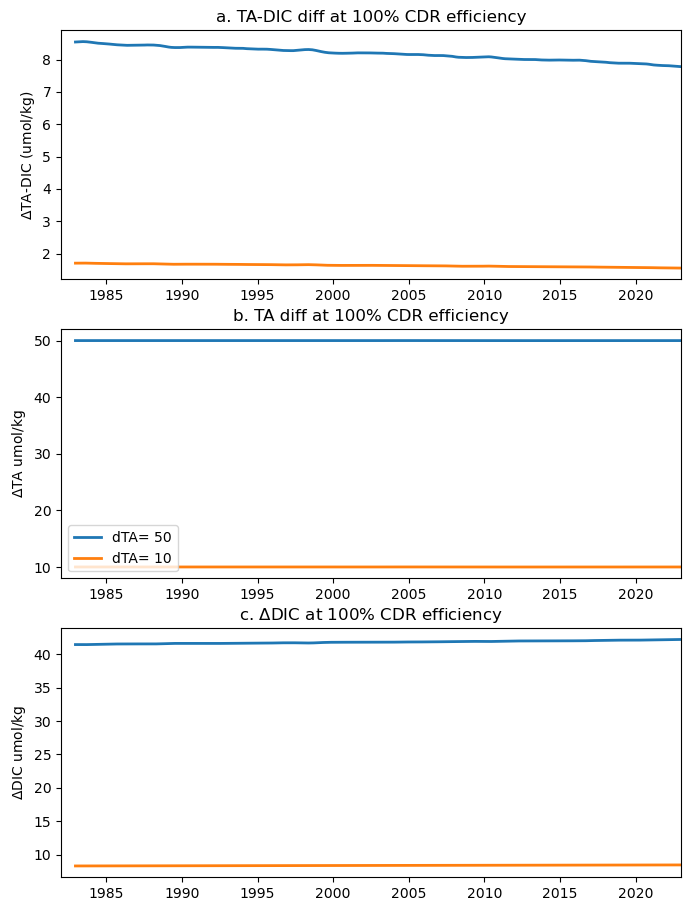

In [15]:
# QA check to see if the computed differences (TA-DIC with dTA) are equal to the perturbation dTA
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplot_mosaic(
    '''
    A
    B
    C
    ''',
    figsize = (8, 11)
)
# - - -
# Plot at ['A']
#
x = np.squeeze(ds_dict["yearfrac"])
var_dTA0 = ds_dict_T["alkstar"].copy()
var_dTA10 = ds_dict_T["alkstar_dTA10"].copy()
var_dTA50 = ds_dict_T["alkstar_dTA50"].copy()
var_dTA100 = ds_dict_T["alkstar_dTA100"].copy()
idx = np.where(np.isnan(var_dTA0) | 
               np.isnan(var_dTA10 ) | 
               np.isnan(var_dTA50) | 
               np.isnan(var_dTA100))[0]
var_dTA0[idx] = np.nan
var_dTA10[idx] = np.nan
var_dTA50[idx] = np.nan
var_dTA100[idx] = np.nan
y0 = np.nanmean(var_dTA0,0)
y1 = np.nanmean(var_dTA10,0) - y0
y2 = np.nanmean(var_dTA50,0) - y0
y3 = np.nanmean(var_dTA100,0) - y0
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
# ax['A'].plot(x, y3, 
#     label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y1, 
    label='dTA=10', linestyle='-', marker='', linewidth=2)
# ax['A'].plot(x, y0, 
#     label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
# ax['A'].plot(x, y_pred, 
#     label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['A'].set_ylabel(r'$\Delta$TA-DIC (umol/kg)')
# ax['A'].legend(loc='lower left')
ax['A'].set_title('a. TA-DIC diff at 100% CDR efficiency')
ax['A'].set_xlim(1982, 2023)
# y_min, y_max = ax['A'].get_ylim()
# y_pos = y_min + 0.95 * (y_max - y_min)
# ax['A'].text(1995, y_pos, f'slope = {10*slope:.1f} umol/kg per decade',
#         fontsize=10, color='black', ha='left', va='center')
# - - -
# Plot at ['B']
#
x = np.squeeze(ds_dict["yearfrac"]).copy()
var_dTA0 = ds_dict_T["talk"].copy()
var_dTA10 = ds_dict_T["talk_dTA10"].copy()
var_dTA50 = ds_dict_T["talk_dTA50"].copy()
var_dTA100 = ds_dict_T["talk_dTA100"].copy()
idx = np.where(np.isnan(var_dTA0) | 
               np.isnan(var_dTA10 ) | 
               np.isnan(var_dTA50) | 
               np.isnan(var_dTA100))[0]
var_dTA0[idx] = np.nan
var_dTA10[idx] = np.nan
var_dTA50[idx] = np.nan
var_dTA100[idx] = np.nan
y0 = np.nanmean(var_dTA0,0)
y1 = np.nanmean(var_dTA10,0) - y0
y2 = np.nanmean(var_dTA50,0) - y0
y3 = np.nanmean(var_dTA100,0) - y0
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
# ax['B'].plot(x, y3, 
#     label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y1, 
    label='dTA= 10', linestyle='-', marker='', linewidth=2)
# ax['B'].plot(x, y0, 
#     label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
# ax['B'].plot(x, y_pred, 
#     label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['B'].set_ylabel(r'$\Delta$TA umol/kg')
ax['B'].legend(loc='lower left')
ax['B'].set_title('b. TA diff at 100% CDR efficiency')
ax['B'].set_xlim(1982, 2023)
# y_min, y_max = ax['B'].get_ylim()
# y_pos = y_min + 0.95 * (y_max - y_min)
# ax['B'].text(1995, y_pos, f'slope = {10*slope:.3f} $\Delta$pH per decade',
#         fontsize=10, color='black', ha='left', va='center')
# - - -
# Plot at ['C']
#
x = np.squeeze(ds_dict["yearfrac"]).copy()
var_dTA0 = ds_dict_T["dic"].copy()
var_dTA10 = ds_dict_T["dic_dTA10"].copy()
var_dTA50 = ds_dict_T["dic_dTA50"].copy()
var_dTA100 = ds_dict_T["dic_dTA100"].copy()
idx = np.where(np.isnan(var_dTA0) | 
               np.isnan(var_dTA10 ) | 
               np.isnan(var_dTA50) | 
               np.isnan(var_dTA100))[0]
var_dTA0[idx] = np.nan
var_dTA10[idx] = np.nan
var_dTA50[idx] = np.nan
var_dTA100[idx] = np.nan
y0 = np.nanmean(var_dTA0,0)
y1 = np.nanmean(var_dTA10,0) - y0
y2 = np.nanmean(var_dTA50,0) - y0
y3 = np.nanmean(var_dTA100,0) - y0
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
# ax['C'].plot(x, y3, 
#     label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y1, 
    label='dTA= 10', linestyle='-', marker='', linewidth=2)
# ax['C'].plot(x, y0, 
#     label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
# ax['C'].plot(x, y_pred, 
#     label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['C'].set_ylabel(r'$\Delta$DIC umol/kg')
# ax['C'].legend(loc='lower left')
ax['C'].set_title(r'c. $\Delta$DIC at 100% CDR efficiency')
ax['C'].set_xlim(1982, 2023);
# y_min, y_max = ax['C'].get_ylim()
# y_pos = y_min + 0.95 * (y_max - y_min)
# ax['C'].text(1995, y_pos, f'slope = {10*slope:.3f} $\Delta\Omega$ar per decade',
#         fontsize=10, color='black', ha='left', va='center')
# - - -

# fig.savefig('Fig8_global_cdreff100_12mo_movmean_alkstar_phtot_omara.png', format='png', dpi=300);

In [16]:
# reshape and transpose outputs
# dTA=10
ds_dict["talk_dTA10"] = np.reshape(ds_dict_T['talk_dTA10'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["dic_dTA10"] = np.reshape(ds_dict_T['dic_dTA10'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["alkstar_dTA10"] = np.reshape(ds_dict_T['alkstar_dTA10'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["phtot_dTA10"] = np.reshape(ds_dict_T['phtot_dTA10'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["omara_dTA10"] = np.reshape(ds_dict_T['omara_dTA10'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["co3_dTA10"] = np.reshape(ds_dict_T['co3_dTA10'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["pco2_dTA10"] = np.reshape(ds_dict_T['pco2_dTA10'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["diceq_dTA10"] = np.reshape(ds_dict_T['diceq_dTA10'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["cdrpot_dTA10"] = np.reshape(ds_dict_T['cdrpot_dTA10'],(NX,NY,NT)).transpose(2,1,0)
# dTA=50
ds_dict["talk_dTA50"] = np.reshape(ds_dict_T['talk_dTA50'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["dic_dTA50"] = np.reshape(ds_dict_T['dic_dTA50'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["alkstar_dTA50"] = np.reshape(ds_dict_T['alkstar_dTA50'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["phtot_dTA50"] = np.reshape(ds_dict_T['phtot_dTA50'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["omara_dTA50"] = np.reshape(ds_dict_T['omara_dTA50'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["co3_dTA50"] = np.reshape(ds_dict_T['co3_dTA50'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["pco2_dTA50"] = np.reshape(ds_dict_T['pco2_dTA50'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["diceq_dTA50"] = np.reshape(ds_dict_T['diceq_dTA50'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["cdrpot_dTA50"] = np.reshape(ds_dict_T['cdrpot_dTA50'],(NX,NY,NT)).transpose(2,1,0)
# dTA=100
ds_dict["talk_dTA100"] = np.reshape(ds_dict_T['talk_dTA100'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["dic_dTA100"] = np.reshape(ds_dict_T['dic_dTA100'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["alkstar_dTA100"] = np.reshape(ds_dict_T['alkstar_dTA100'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["phtot_dTA100"] = np.reshape(ds_dict_T['phtot_dTA100'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["omara_dTA100"] = np.reshape(ds_dict_T['omara_dTA100'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["co3_dTA100"] = np.reshape(ds_dict_T['co3_dTA100'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["pco2_dTA100"] = np.reshape(ds_dict_T['pco2_dTA100'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["diceq_dTA100"] = np.reshape(ds_dict_T['diceq_dTA100'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["cdrpot_dTA100"] = np.reshape(ds_dict_T['cdrpot_dTA100'],(NX,NY,NT)).transpose(2,1,0)

In [17]:
# make x_mesh and y_mesh arrays for use in regional selections
ds_dict['x_mesh'],ds_dict['y_mesh'] = np.meshgrid(ds_dict['x'],ds_dict['y'])
ds_dict_T["x_mesh"] = np.transpose(ds_dict['x_mesh'],(1,0)).reshape(NX*NY)
ds_dict_T["y_mesh"] = np.transpose(ds_dict['y_mesh'],(1,0)).reshape(NX*NY)

In [7]:
# Save or load the results to or from mat files 

tic()
print('Saving or loading output mat file, please wait...')

# Save the results in a mat file
# scipy.io.savemat('OceanSODA_ETHZ_for_PyOAE_with_dTA_at_CDReff100_ds_dict_v20250426.mat', ds_dict)
# scipy.io.savemat('OceanSODA_ETHZ_for_PyOAE_with_dTA_at_CDReff100_ds_dict_T_v20250426.mat', ds_dict_T)

# load previously saved mat file into ds_dict
ds_dict = scipy.io.loadmat('OceanSODA_ETHZ_for_PyOAE_with_dTA_at_CDReff100_ds_dict_v20250426.mat')
ds_dict_T = scipy.io.loadmat('OceanSODA_ETHZ_for_PyOAE_with_dTA_at_CDReff100_ds_dict_T_v20250426.mat')

print('Done')
toc()

Saving or loading output mat file, please wait...
Done
Elapsed time: 129.344882 seconds.



In [8]:
# QA check RMSE difference between matlab vs python co2sys calc variables for dTA100

# load previously calculated control conditions from matlab co2sys
matlab_pco2_dTA100 = scipy.io.loadmat('matlab_cdreff100_dTA100_pco2.mat')
matlab_phtot_dTA100 = scipy.io.loadmat('matlab_cdreff100_dTA100_phtot.mat')
matlab_omara_dTA100 = scipy.io.loadmat('matlab_cdreff100_dTA100_omara.mat')
matlab_alkstar_dTA100 = scipy.io.loadmat('matlab_cdreff100_dTA100_alkstar.mat')

# transpose matlab arrays to same format as python arrays
matlab_pco2_dTA100 = np.transpose(matlab_pco2_dTA100['pco2_d_talk_100'],(2,1,0))
matlab_phtot_dTA100 = np.transpose(matlab_phtot_dTA100['phtot_d_talk_100'],(2,1,0))
matlab_omara_dTA100 = np.transpose(matlab_omara_dTA100['omara_d_talk_100'],(2,1,0))
matlab_alkstar_dTA100 = np.transpose(matlab_alkstar_dTA100['alkstar_d_talk_100'],(2,1,0))

# pCO2
dif_pco2 = ds_dict['pco2_dTA100'] - matlab_pco2_dTA100
print('nnn(dif_pco2_dTA100): ',nnn(dif_pco2))
print('rmse(dif_pco2_dTA100): ',np.sqrt(np.nanmean(dif_pco2**2)))

# pHtot
dif_phtot = ds_dict['phtot_dTA100'] - matlab_phtot_dTA100
print('nnn(dif_phtot_dTA100): ',nnn(dif_phtot))
print('rmse(dif_phtot_dTA100): ',np.sqrt(np.nanmean(dif_phtot**2)))

# OmegaAr
dif_omara = ds_dict['omara_dTA100'] - matlab_omara_dTA100
print('nnn(dif_omara_dTA100): ',nnn(dif_omara))
print('rmse(dif_omara_dTA100): ',np.sqrt(np.nanmean(dif_omara**2)))

# TA-DIC
dif_alkstar = ds_dict['alkstar_dTA100'] - matlab_alkstar_dTA100
print('nnn(dif_alkstar_dTA100): ',nnn(dif_alkstar))
print('rmse(dif_alkstar_dTA100): ',np.sqrt(np.nanmean(dif_alkstar**2)))

nnn(dif_pco2_dTA100):  18208647
rmse(dif_pco2_dTA100):  0.00017883577053593567
nnn(dif_phtot_dTA100):  18208647
rmse(dif_phtot_dTA100):  3.328322976984771e-07
nnn(dif_omara_dTA100):  18208647
rmse(dif_omara_dTA100):  9.131987726450472e-07
nnn(dif_alkstar_dTA100):  18208647
rmse(dif_alkstar_dTA100):  6.536282844652483e-05


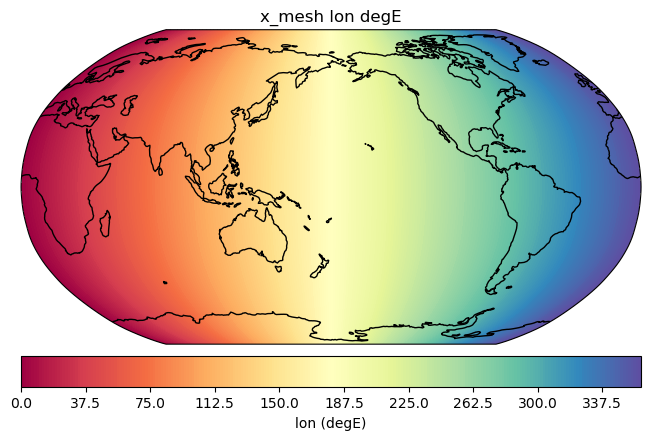

In [9]:
# QA check x_mesh
import cartopy.crs as ccrs
from matplotlib.colors import TwoSlopeNorm
plt.figure(figsize=(8, 5))
X = np.squeeze(ds_dict['x'])
Y = np.squeeze(ds_dict['y'])
Z = ds_dict['x_mesh']
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines()
plt.title(r'x_mesh lon degE')
plt.contourf(X,Y,Z,cmap='Spectral',levels=256,transform=ccrs.PlateCarree());
plt.colorbar(orientation="horizontal", pad=0.03,label=r'lon (degE)');

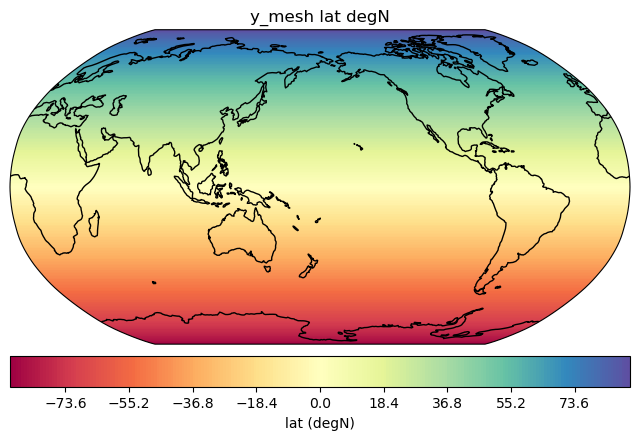

In [10]:
# QA check y_mesh
import cartopy.crs as ccrs
from matplotlib.colors import TwoSlopeNorm
plt.figure(figsize=(8, 5))
X = np.squeeze(ds_dict['x'])
Y = np.squeeze(ds_dict['y'])
Z = ds_dict['y_mesh']
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines()
plt.title(r'y_mesh lat degN')
plt.contourf(X,Y,Z,cmap='Spectral',levels=256,transform=ccrs.PlateCarree());
plt.colorbar(orientation="horizontal", pad=0.03,label=r'lat (degN)');

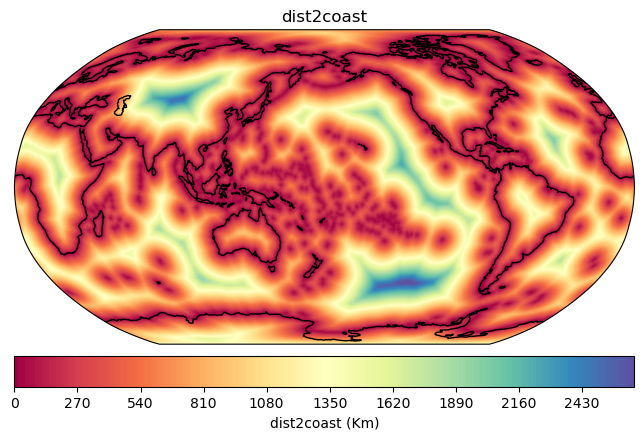

In [11]:
# QA check dist2coast
import cartopy.crs as ccrs
from matplotlib.colors import TwoSlopeNorm
plt.figure(figsize=(8, 5))
X = np.squeeze(ds_dict['x'])
Y = np.squeeze(ds_dict['y'])
Z = ds_dict['dist2coast']
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines()
plt.title(r'dist2coast')
plt.contourf(X,Y,Z,cmap='Spectral',levels=256,transform=ccrs.PlateCarree());
plt.colorbar(orientation="horizontal", pad=0.03,label=r'dist2coast (Km)');

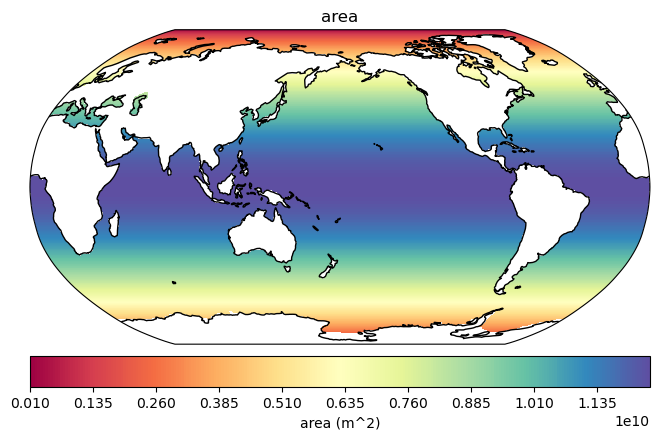

In [12]:
# QA check area
# ds_dict_T["area"] = np.transpose(ds_dict['area'],(1,0)).reshape(NX*NY)
import cartopy.crs as ccrs
from matplotlib.colors import TwoSlopeNorm
plt.figure(figsize=(8, 5))
X = np.squeeze(ds_dict['x'])
Y = np.squeeze(ds_dict['y'])
Z = ds_dict['area']
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines()
plt.title(r'area')
plt.contourf(X,Y,Z,cmap='Spectral',levels=256,transform=ccrs.PlateCarree());
plt.colorbar(orientation="horizontal", pad=0.03,label=r'area (m^2)');

In [13]:
# find idx indices to select polar and coastal regions using vectorized data

# make x_mesh and y_mesh arrays for use in regional selections
ds_dict['x_mesh'],ds_dict['y_mesh'] = np.meshgrid(ds_dict['x'],ds_dict['y'])
ds_dict_T["x_mesh"] = np.transpose(ds_dict['x_mesh'],(1,0)).reshape(NX*NY)
ds_dict_T["y_mesh"] = np.transpose(ds_dict['y_mesh'],(1,0)).reshape(NX*NY)

# idx to select polar region >60 deg N or S

# arr = ds_dict_T["y_mesh"].copy()
# arr_talk = ds_dict_T["alkstar"][:,0]
# condition = ((arr <= -60) | (arr >= 60)) & ~np.isnan(arr_talk)
# idx_polar = np.where(condition)[0]
# condition = ((arr > -60) & (arr < 60)) & ~np.isnan(arr_talk)
# idx_notpolar = np.where(condition)[0]

arr = ds_dict_T["y_mesh"].copy()
condition = ((arr <= -60) | (arr >= 60))
idx_polar = np.where(condition)[0]
condition = ((arr > -60) & (arr < 60))
idx_notpolar = np.where(condition)[0]

# idx to select coastal region within 300km of the nearest coast

# ds_dict_T["dist2coast"] = np.transpose(ds_dict['dist2coast'],(1,0)).reshape(NX*NY)
# arr = ds_dict_T["dist2coast"].copy()
# arr_talk = ds_dict_T["alkstar"][:,0]
# condition = (arr <= 300) & ~np.isnan(arr_talk)
# idx_coastal = np.where(condition)[0]
# condition = (arr > 300) & ~np.isnan(arr_talk)
# idx_notcoastal = np.where(condition)[0]

ds_dict_T["dist2coast"] = np.transpose(ds_dict['dist2coast'],(1,0)).reshape(NX*NY)
arr = ds_dict_T["dist2coast"].copy()
condition = (arr <= 300) 
idx_coastal = np.where(condition)[0]
condition = (arr > 300)
idx_notcoastal = np.where(condition)[0]


In [14]:
# function to make subset for polar or coastal using idx_notsubset
def make_subset(global_T, idx):
    # global_T= global ds_dict_T variable (NX*NY,NT)
    # idx= indices that are not in the regional subset of global_T
    subset_T = global_T.copy()
    subset_T[idx,:] = np.nan
    subset = np.reshape(subset_T,(NX,NY,NT)).transpose(2,1,0)
    return subset, subset_T    

In [15]:
# keep only the values that are non-nan in all co2sys output arrays

var1_dTA0 = ds_dict_T["talk"].copy()
var2_dTA0 = ds_dict_T["dic"].copy()
var3_dTA0 = ds_dict_T["alkstar"].copy()
var4_dTA0 = ds_dict_T["omara"].copy()
var5_dTA0 = ds_dict_T["co3"].copy()
var6_dTA0 = ds_dict_T["phtot"].copy()

var1_dTA10 = ds_dict_T["talk_dTA10"].copy()
var2_dTA10 = ds_dict_T["dic_dTA10"].copy()
var3_dTA10 = ds_dict_T["alkstar_dTA10"].copy()
var4_dTA10 = ds_dict_T["omara_dTA10"].copy()
var5_dTA10 = ds_dict_T["co3_dTA10"].copy()
var6_dTA10 = ds_dict_T["phtot_dTA10"].copy()

var1_dTA50 = ds_dict_T["talk_dTA50"].copy()
var2_dTA50 = ds_dict_T["dic_dTA50"].copy()
var3_dTA50 = ds_dict_T["alkstar_dTA50"].copy()
var4_dTA50 = ds_dict_T["omara_dTA50"].copy()
var5_dTA50 = ds_dict_T["co3_dTA50"].copy()
var6_dTA50 = ds_dict_T["phtot_dTA50"].copy()

var1_dTA100 = ds_dict_T["talk_dTA100"].copy()
var2_dTA100 = ds_dict_T["dic_dTA100"].copy()
var3_dTA100 = ds_dict_T["alkstar_dTA100"].copy()
var4_dTA100 = ds_dict_T["omara_dTA100"].copy()
var5_dTA100 = ds_dict_T["co3_dTA100"].copy()
var6_dTA100 = ds_dict_T["phtot_dTA100"].copy()

idx = np.where(np.isnan(var1_dTA0 + var2_dTA0 + var3_dTA0 + var4_dTA0 + var5_dTA0 + var6_dTA0 +
                var1_dTA10 + var2_dTA10 + var3_dTA10 + var4_dTA10 + var5_dTA10 + var6_dTA10 +
                var1_dTA50 + var2_dTA50 + var3_dTA50 + var4_dTA50 + var5_dTA50 + var6_dTA50 +
                var1_dTA100 + var2_dTA100 + var3_dTA100 + var4_dTA100 + var5_dTA100 + var6_dTA100
                )) 

var1_dTA0[idx] = np.nan
var2_dTA0[idx] = np.nan
var3_dTA0[idx] = np.nan
var4_dTA0[idx] = np.nan
var5_dTA0[idx] = np.nan
var6_dTA0[idx] = np.nan

var1_dTA10[idx] = np.nan
var2_dTA10[idx] = np.nan
var3_dTA10[idx] = np.nan
var4_dTA10[idx] = np.nan
var5_dTA10[idx] = np.nan
var6_dTA10[idx] = np.nan

var1_dTA50[idx] = np.nan
var2_dTA50[idx] = np.nan
var3_dTA50[idx] = np.nan
var4_dTA50[idx] = np.nan
var5_dTA50[idx] = np.nan
var6_dTA50[idx] = np.nan

var1_dTA100[idx] = np.nan
var2_dTA100[idx] = np.nan
var3_dTA100[idx] = np.nan
var4_dTA100[idx] = np.nan
var5_dTA100[idx] = np.nan
var6_dTA100[idx] = np.nan

ds_dict_T["talk_global_dTA0"] = var1_dTA0
ds_dict_T["dic_global_dTA0"] = var2_dTA0
ds_dict_T["alkstar_global_dTA0"] = var3_dTA0
ds_dict_T["omara_global_dTA0"] = var4_dTA0
ds_dict_T["co3_global_dTA0"] = var5_dTA0
ds_dict_T["phtot_global_dTA0"] = var6_dTA0

ds_dict_T["talk_global_dTA10"] = var1_dTA10
ds_dict_T["dic_global_dTA10"] = var2_dTA10
ds_dict_T["alkstar_global_dTA10"] = var3_dTA10
ds_dict_T["omara_global_dTA10"] = var4_dTA10
ds_dict_T["co3_global_dTA10"] = var5_dTA10
ds_dict_T["phtot_global_dTA10"] = var6_dTA10

ds_dict_T["talk_global_dTA50"] = var1_dTA50
ds_dict_T["dic_global_dTA50"] = var2_dTA50
ds_dict_T["alkstar_global_dTA50"] = var3_dTA50
ds_dict_T["omara_global_dTA50"] = var4_dTA50
ds_dict_T["co3_global_dTA50"] = var5_dTA50
ds_dict_T["phtot_global_dTA50"] = var6_dTA50

ds_dict_T["talk_global_dTA100"] = var1_dTA100
ds_dict_T["dic_global_dTA100"] = var2_dTA100
ds_dict_T["alkstar_global_dTA100"] = var3_dTA100
ds_dict_T["omara_global_dTA100"] = var4_dTA100
ds_dict_T["co3_global_dTA100"] = var5_dTA100
ds_dict_T["phtot_global_dTA100"] = var6_dTA100

print('nnn(talk_dTA0): ',nnn(ds_dict_T["talk_global_dTA0"]))
print('nnn(dic_dTA0): ',nnn(ds_dict_T["dic_global_dTA0"]))
print('nnn(alkstar_dTA0): ',nnn(ds_dict_T["alkstar_global_dTA0"]))
print('nnn(omara_dTA0): ',nnn( ds_dict_T["omara_global_dTA0"]))
print('nnn(co3_dTA0): ',nnn(ds_dict_T["co3_global_dTA0"]))
print('nnn(phtot_dTA0): ',nnn(ds_dict_T["phtot_global_dTA0"]))

print('nnn(talk_dTA10): ',nnn(ds_dict_T["talk_global_dTA10"]))
print('nnn(dic_dTA10): ',nnn(ds_dict_T["dic_global_dTA10"]))
print('nnn(alkstar_dTA10): ',nnn(ds_dict_T["alkstar_global_dTA10"]))
print('nnn(omara_dTA10): ',nnn( ds_dict_T["omara_global_dTA10"]))
print('nnn(co3_dTA10): ',nnn(ds_dict_T["co3_global_dTA10"]))
print('nnn(phtot_dTA10): ',nnn(ds_dict_T["phtot_global_dTA10"]))

print('nnn(talk_dTA50): ',nnn(ds_dict_T["talk_global_dTA50"]))
print('nnn(dic_dTA50): ',nnn(ds_dict_T["dic_global_dTA50"]))
print('nnn(alkstar_dTA50): ',nnn(ds_dict_T["alkstar_global_dTA50"]))
print('nnn(omara_dTA50): ',nnn( ds_dict_T["omara_global_dTA50"]))
print('nnn(co3_dTA50): ',nnn(ds_dict_T["co3_global_dTA50"]))
print('nnn(phtot_dTA50): ',nnn(ds_dict_T["phtot_global_dTA50"]))

print('nnn(talk_dTA100): ',nnn(ds_dict_T["talk_global_dTA100"]))
print('nnn(dic_dTA100): ',nnn(ds_dict_T["dic_global_dTA100"]))
print('nnn(alkstar_dTA100): ',nnn(ds_dict_T["alkstar_global_dTA100"]))
print('nnn(omara_dTA100): ',nnn( ds_dict_T["omara_global_dTA100"]))
print('nnn(co3_dTA100): ',nnn(ds_dict_T["co3_global_dTA100"]))
print('nnn(phtot_dTA100): ',nnn(ds_dict_T["phtot_global_dTA100"]))


nnn(talk_dTA0):  18208647
nnn(dic_dTA0):  18208647
nnn(alkstar_dTA0):  18208647
nnn(omara_dTA0):  18208647
nnn(co3_dTA0):  18208647
nnn(phtot_dTA0):  18208647
nnn(talk_dTA10):  18208647
nnn(dic_dTA10):  18208647
nnn(alkstar_dTA10):  18208647
nnn(omara_dTA10):  18208647
nnn(co3_dTA10):  18208647
nnn(phtot_dTA10):  18208647
nnn(talk_dTA50):  18208647
nnn(dic_dTA50):  18208647
nnn(alkstar_dTA50):  18208647
nnn(omara_dTA50):  18208647
nnn(co3_dTA50):  18208647
nnn(phtot_dTA50):  18208647
nnn(talk_dTA100):  18208647
nnn(dic_dTA100):  18208647
nnn(alkstar_dTA100):  18208647
nnn(omara_dTA100):  18208647
nnn(co3_dTA100):  18208647
nnn(phtot_dTA100):  18208647


In [16]:
# QA check global to compare with matlab

print('- - -')
print('QA check global to compare with matlab')
print('- - -')
print('dTA=0')

print('TA')
print('nnn(talk_dTA0): ',nnn(ds_dict_T["talk_global_dTA0"]))
print('nanmean(talk_dTA0): ',np.nanmean(ds_dict_T["talk_global_dTA0"]))
print('nanmax(talk_dTA0): ',np.nanmax(ds_dict_T["talk_global_dTA0"]))
print('nanmin(talk_dTA0): ',np.nanmin(ds_dict_T["talk_global_dTA0"]))

print('DIC')
print('nnn(dic_dTA0): ',nnn(ds_dict_T["dic_global_dTA0"]))
print('nanmean(dic_dTA0): ',np.nanmean(ds_dict_T["dic_global_dTA0"]))
print('nanmax(dic_dTA0): ',np.nanmax(ds_dict_T["dic_global_dTA0"]))
print('nanmin(dic_dTA0): ',np.nanmin(ds_dict_T["dic_global_dTA0"]))

print('TA-DIC')
print('nnn(alkstar_dTA0): ',nnn(ds_dict_T["alkstar_global_dTA0"]))
print('nanmean(alkstar_dTA0): ',np.nanmean(ds_dict_T["alkstar_global_dTA0"]))
print('nanmax(alkstar_dTA0): ',np.nanmax(ds_dict_T["alkstar_global_dTA0"]))
print('nanmin(alkstar_dTA0): ',np.nanmin(ds_dict_T["alkstar_global_dTA0"]))

print('- - -')
print('dTA=10')

print('TA')
print('nnn(talk_dTA10): ',nnn(ds_dict_T["talk_global_dTA10"]))
print('nanmean(talk_dTA10): ',np.nanmean(ds_dict_T["talk_global_dTA10"]))
print('nanmax(talk_dTA10): ',np.nanmax(ds_dict_T["talk_global_dTA10"]))
print('nanmin(talk_dTA10): ',np.nanmin(ds_dict_T["talk_global_dTA10"]))

print('DIC')
print('nnn(dic_dTA10): ',nnn(ds_dict_T["dic_global_dTA10"]))
print('nanmean(dic_dTA10): ',np.nanmean(ds_dict_T["dic_global_dTA10"]))
print('nanmax(dic_dTA10): ',np.nanmax(ds_dict_T["dic_global_dTA10"]))
print('nanmin(dic_dTA10): ',np.nanmin(ds_dict_T["dic_global_dTA10"]))

print('TA-DIC')
print('nnn(alkstar_dTA10): ',nnn(ds_dict_T["alkstar_global_dTA10"]))
print('nanmean(alkstar_dTA10): ',np.nanmean(ds_dict_T["alkstar_global_dTA10"]))
print('nanmax(alkstar_dTA10): ',np.nanmax(ds_dict_T["alkstar_global_dTA10"]))
print('nanmin(alkstar_dTA10): ',np.nanmin(ds_dict_T["alkstar_global_dTA10"]))

print('- - -')
print('dTA=50')

print('TA')
print('nnn(talk_dTA50): ',nnn(ds_dict_T["talk_global_dTA50"]))
print('nanmean(talk_dTA50): ',np.nanmean(ds_dict_T["talk_global_dTA50"]))
print('nanmax(talk_dTA50): ',np.nanmax(ds_dict_T["talk_global_dTA50"]))
print('nanmin(talk_dTA50): ',np.nanmin(ds_dict_T["talk_global_dTA50"]))

print('DIC')
print('nnn(dic_dTA50): ',nnn(ds_dict_T["dic_global_dTA50"]))
print('nanmean(dic_dTA50): ',np.nanmean(ds_dict_T["dic_global_dTA50"]))
print('nanmax(dic_dTA50): ',np.nanmax(ds_dict_T["dic_global_dTA50"]))
print('nanmin(dic_dTA50): ',np.nanmin(ds_dict_T["dic_global_dTA50"]))

print('TA-DIC')
print('nnn(alkstar_dTA50): ',nnn(ds_dict_T["alkstar_global_dTA50"]))
print('nanmean(alkstar_dTA50): ',np.nanmean(ds_dict_T["alkstar_global_dTA50"]))
print('nanmax(alkstar_dTA50): ',np.nanmax(ds_dict_T["alkstar_global_dTA50"]))
print('nanmin(alkstar_dTA50): ',np.nanmin(ds_dict_T["alkstar_global_dTA50"]))

print('- - -')
print('dTA=100')

print('TA')
print('nnn(talk_dTA100): ',nnn(ds_dict_T["talk_global_dTA100"]))
print('nanmean(talk_dTA100): ',np.nanmean(ds_dict_T["talk_global_dTA100"]))
print('nanmax(talk_dTA100): ',np.nanmax(ds_dict_T["talk_global_dTA100"]))
print('nanmin(talk_dTA100): ',np.nanmin(ds_dict_T["talk_global_dTA100"]))

print('DIC')
print('nnn(dic_dTA100): ',nnn(ds_dict_T["dic_global_dTA100"]))
print('nanmean(dic_dTA100): ',np.nanmean(ds_dict_T["dic_global_dTA100"]))
print('nanmax(dic_dTA10): ',np.nanmax(ds_dict_T["dic_global_dTA100"]))
print('nanmin(dic_dTA100): ',np.nanmin(ds_dict_T["dic_global_dTA100"]))

print('TA-DIC')
print('nnn(alkstar_dTA100): ',nnn(ds_dict_T["alkstar_global_dTA100"]))
print('nanmean(alkstar_dTA100): ',np.nanmean(ds_dict_T["alkstar_global_dTA100"]))
print('nanmax(alkstar_dTA100): ',np.nanmax(ds_dict_T["alkstar_global_dTA100"]))
print('nanmin(alkstar_dTA100): ',np.nanmin(ds_dict_T["alkstar_global_dTA100"]))


- - -
QA check global to compare with matlab
- - -
dTA=0
TA
nnn(talk_dTA0):  18208647
nanmean(talk_dTA0):  2289.441
nanmax(talk_dTA0):  2696.5103
nanmin(talk_dTA0):  1000.0
DIC
nnn(dic_dTA0):  18208647
nanmean(dic_dTA0):  2040.5375
nanmax(dic_dTA0):  2387.978
nanmin(dic_dTA0):  1.3067748e-12
TA-DIC
nnn(alkstar_dTA0):  18208647
nanmean(alkstar_dTA0):  248.90575
nanmax(alkstar_dTA0):  2305.2266
nanmin(alkstar_dTA0):  -97.79895
- - -
dTA=10
TA
nnn(talk_dTA10):  18208647
nanmean(talk_dTA10):  2299.4403834771115
nanmax(talk_dTA10):  2706.51025390625
nanmin(talk_dTA10):  1010.0
DIC
nnn(dic_dTA10):  18208647
nanmean(dic_dTA10):  2048.9436663795254
nanmax(dic_dTA10):  2396.360717306551
nanmin(dic_dTA10):  1.0900571740903716e-12
TA-DIC
nnn(alkstar_dTA10):  18208647
nanmean(alkstar_dTA10):  250.49671709758655
nanmax(alkstar_dTA10):  2315.226562499999
nanmin(alkstar_dTA10):  -97.62617965898994
- - -
dTA=50
TA
nnn(talk_dTA50):  18208647
nanmean(talk_dTA50):  2339.440383478409
nanmax(talk_dTA50):  

In [17]:
# create polar and coastal subsets

# # # polar subset
# - unperturbed
ds_dict['talk_polar_dTA0'], ds_dict_T['talk_polar_dTA0'] = make_subset(ds_dict_T['talk_global_dTA0'], idx_notpolar)
ds_dict['dic_polar_dTA0'], ds_dict_T['dic_polar_dTA0'] = make_subset(ds_dict_T['dic_global_dTA0'], idx_notpolar)
ds_dict['alkstar_polar_dTA0'], ds_dict_T['alkstar_polar_dTA0'] = make_subset(ds_dict_T['alkstar_global_dTA0'], idx_notpolar)
ds_dict['omara_polar_dTA0'], ds_dict_T['omara_polar_dTA0'] = make_subset(ds_dict_T['omara_global_dTA0'], idx_notpolar)
ds_dict['co3_polar_dTA0'], ds_dict_T['co3_polar_dTA0'] = make_subset(ds_dict_T['co3_global_dTA0'], idx_notpolar)
ds_dict['phtot_polar_dTA0'], ds_dict_T['phtot_polar_dTA0'] = make_subset(ds_dict_T['phtot_global_dTA0'], idx_notpolar)
# - dTA10
ds_dict['talk_polar_dTA10'], ds_dict_T['talk_polar_dTA10'] = make_subset(ds_dict_T['talk_global_dTA10'], idx_notpolar)
ds_dict['dic_polar_dTA10'], ds_dict_T['dic_polar_dTA10'] = make_subset(ds_dict_T['dic_global_dTA10'], idx_notpolar)
ds_dict['alkstar_polar_dTA10'], ds_dict_T['alkstar_polar_dTA10'] = make_subset(ds_dict_T['alkstar_global_dTA10'], idx_notpolar)
ds_dict['omara_polar_dTA10'], ds_dict_T['omara_polar_dTA10'] = make_subset(ds_dict_T['omara_global_dTA10'], idx_notpolar)
ds_dict['co3_polar_dTA10'], ds_dict_T['co3_polar_dTA10'] = make_subset(ds_dict_T['co3_global_dTA10'], idx_notpolar)
ds_dict['phtot_polar_dTA10'], ds_dict_T['phtot_polar_dTA10'] = make_subset(ds_dict_T['phtot_global_dTA10'], idx_notpolar)
# - dTA50
ds_dict['talk_polar_dTA50'], ds_dict_T['talk_polar_dTA50'] = make_subset(ds_dict_T['talk_global_dTA50'], idx_notpolar)
ds_dict['dic_polar_dTA50'], ds_dict_T['dic_polar_dTA50'] = make_subset(ds_dict_T['dic_global_dTA50'], idx_notpolar)
ds_dict['alkstar_polar_dTA50'], ds_dict_T['alkstar_polar_dTA50'] = make_subset(ds_dict_T['alkstar_global_dTA50'], idx_notpolar)
ds_dict['omara_polar_dTA50'], ds_dict_T['omara_polar_dTA50'] = make_subset(ds_dict_T['omara_global_dTA50'], idx_notpolar)
ds_dict['co3_polar_dTA50'], ds_dict_T['co3_polar_dTA50'] = make_subset(ds_dict_T['co3_global_dTA50'], idx_notpolar)
ds_dict['phtot_polar_dTA50'], ds_dict_T['phtot_polar_dTA50'] = make_subset(ds_dict_T['phtot_global_dTA50'], idx_notpolar)
# - dTA100
ds_dict['talk_polar_dTA100'], ds_dict_T['talk_polar_dTA100'] = make_subset(ds_dict_T['talk_global_dTA100'], idx_notpolar)
ds_dict['dic_polar_dTA100'], ds_dict_T['dic_polar_dTA100'] = make_subset(ds_dict_T['dic_global_dTA100'], idx_notpolar)
ds_dict['alkstar_polar_dTA100'], ds_dict_T['alkstar_polar_dTA100'] = make_subset(ds_dict_T['alkstar_global_dTA100'], idx_notpolar)
ds_dict['omara_polar_dTA100'], ds_dict_T['omara_polar_dTA100'] = make_subset(ds_dict_T['omara_global_dTA100'], idx_notpolar)
ds_dict['co3_polar_dTA100'], ds_dict_T['co3_polar_dTA100'] = make_subset(ds_dict_T['co3_global_dTA100'], idx_notpolar)
ds_dict['phtot_polar_dTA100'], ds_dict_T['phtot_polar_dTA100'] = make_subset(ds_dict_T['phtot_global_dTA100'], idx_notpolar)

# # # coastal subset
# - unperturbed
ds_dict['talk_coastal_dTA0'], ds_dict_T['talk_coastal_dTA0'] = make_subset(ds_dict_T['talk_global_dTA0'], idx_notcoastal)
ds_dict['dic_coastal_dTA0'], ds_dict_T['dic_coastal_dTA0'] = make_subset(ds_dict_T['dic_global_dTA0'], idx_notcoastal)
ds_dict['alkstar_coastal_dTA0'], ds_dict_T['alkstar_coastal_dTA0'] = make_subset(ds_dict_T['alkstar_global_dTA0'], idx_notcoastal)
ds_dict['omara_coastal_dTA0'], ds_dict_T['omara_coastal_dTA0'] = make_subset(ds_dict_T['omara_global_dTA0'], idx_notcoastal)
ds_dict['co3_coastal_dTA0'], ds_dict_T['co3_coastal_dTA0'] = make_subset(ds_dict_T['co3_global_dTA0'], idx_notcoastal)
ds_dict['phtot_coastal_dTA0'], ds_dict_T['phtot_coastal_dTA0'] = make_subset(ds_dict_T['phtot_global_dTA0'], idx_notcoastal)
# - dTA10
ds_dict['talk_coastal_dTA10'], ds_dict_T['talk_coastal_dTA10'] = make_subset(ds_dict_T['talk_global_dTA10'], idx_notcoastal)
ds_dict['dic_coastal_dTA10'], ds_dict_T['dic_coastal_dTA10'] = make_subset(ds_dict_T['dic_global_dTA10'], idx_notcoastal)
ds_dict['alkstar_coastal_dTA10'], ds_dict_T['alkstar_coastal_dTA10'] = make_subset(ds_dict_T['alkstar_global_dTA10'], idx_notcoastal)
ds_dict['omara_coastal_dTA10'], ds_dict_T['omara_coastal_dTA10'] = make_subset(ds_dict_T['omara_global_dTA10'], idx_notcoastal)
ds_dict['co3_coastal_dTA10'], ds_dict_T['co3_coastal_dTA10'] = make_subset(ds_dict_T['co3_global_dTA10'], idx_notcoastal)
ds_dict['phtot_coastal_dTA10'], ds_dict_T['phtot_coastal_dTA10'] = make_subset(ds_dict_T['phtot_global_dTA10'], idx_notcoastal)
# - dTA50
ds_dict['talk_coastal_dTA50'], ds_dict_T['talk_coastal_dTA50'] = make_subset(ds_dict_T['talk_global_dTA50'], idx_notcoastal)
ds_dict['dic_coastal_dTA50'], ds_dict_T['dic_coastal_dTA50'] = make_subset(ds_dict_T['dic_global_dTA50'], idx_notcoastal)
ds_dict['alkstar_coastal_dTA50'], ds_dict_T['alkstar_coastal_dTA50'] = make_subset(ds_dict_T['alkstar_global_dTA50'], idx_notcoastal)
ds_dict['omara_coastal_dTA50'], ds_dict_T['omara_coastal_dTA50'] = make_subset(ds_dict_T['omara_global_dTA50'], idx_notcoastal)
ds_dict['co3_coastal_dTA50'], ds_dict_T['co3_coastal_dTA50'] = make_subset(ds_dict_T['co3_global_dTA50'], idx_notcoastal)
ds_dict['phtot_coastal_dTA50'], ds_dict_T['phtot_coastal_dTA50'] = make_subset(ds_dict_T['phtot_global_dTA50'], idx_notcoastal)
# - dTA100
ds_dict['talk_coastal_dTA100'], ds_dict_T['talk_coastal_dTA100'] = make_subset(ds_dict_T['talk_global_dTA100'], idx_notcoastal)
ds_dict['dic_coastal_dTA100'], ds_dict_T['dic_coastal_dTA100'] = make_subset(ds_dict_T['dic_global_dTA100'], idx_notcoastal)
ds_dict['alkstar_coastal_dTA100'], ds_dict_T['alkstar_coastal_dTA100'] = make_subset(ds_dict_T['alkstar_global_dTA100'], idx_notcoastal)
ds_dict['omara_coastal_dTA100'], ds_dict_T['omara_coastal_dTA100'] = make_subset(ds_dict_T['omara_global_dTA100'], idx_notcoastal)
ds_dict['co3_coastal_dTA100'], ds_dict_T['co3_coastal_dTA100'] = make_subset(ds_dict_T['co3_global_dTA100'], idx_notcoastal)
ds_dict['phtot_coastal_dTA100'], ds_dict_T['phtot_coastal_dTA100'] = make_subset(ds_dict_T['phtot_global_dTA100'], idx_notcoastal)

In [18]:
# QA check coastal to compare with matlab

print('- - -')
print('QA check coastal to compare with matlab')
print('- - -')
print('dTA=0')

print('TA')
print('nnn(talk_dTA0): ',nnn(ds_dict_T["talk_coastal_dTA0"]))
print('nanmean(talk_dTA0): ',np.nanmean(ds_dict_T["talk_coastal_dTA0"]))
print('nanmax(talk_dTA0): ',np.nanmax(ds_dict_T["talk_coastal_dTA0"]))
print('nanmin(talk_dTA0): ',np.nanmin(ds_dict_T["talk_coastal_dTA0"]))

print('DIC')
print('nnn(dic_dTA0): ',nnn(ds_dict_T["dic_coastal_dTA0"]))
print('nanmean(dic_dTA0): ',np.nanmean(ds_dict_T["dic_coastal_dTA0"]))
print('nanmax(dic_dTA0): ',np.nanmax(ds_dict_T["dic_coastal_dTA0"]))
print('nanmin(dic_dTA0): ',np.nanmin(ds_dict_T["dic_coastal_dTA0"]))

print('TA-DIC')
print('nnn(alkstar_dTA0): ',nnn(ds_dict_T["alkstar_coastal_dTA0"]))
print('nanmean(alkstar_dTA0): ',np.nanmean(ds_dict_T["alkstar_coastal_dTA0"]))
print('nanmax(alkstar_dTA0): ',np.nanmax(ds_dict_T["alkstar_coastal_dTA0"]))
print('nanmin(alkstar_dTA0): ',np.nanmin(ds_dict_T["alkstar_coastal_dTA0"]))

print('- - -')
print('dTA=10')

print('TA')
print('nnn(talk_dTA10): ',nnn(ds_dict_T["talk_coastal_dTA10"]))
print('nanmean(talk_dTA10): ',np.nanmean(ds_dict_T["talk_coastal_dTA10"]))
print('nanmax(talk_dTA10): ',np.nanmax(ds_dict_T["talk_coastal_dTA10"]))
print('nanmin(talk_dTA10): ',np.nanmin(ds_dict_T["talk_coastal_dTA10"]))

print('DIC')
print('nnn(dic_dTA10): ',nnn(ds_dict_T["dic_coastal_dTA10"]))
print('nanmean(dic_dTA10): ',np.nanmean(ds_dict_T["dic_coastal_dTA10"]))
print('nanmax(dic_dTA10): ',np.nanmax(ds_dict_T["dic_coastal_dTA10"]))
print('nanmin(dic_dTA10): ',np.nanmin(ds_dict_T["dic_coastal_dTA10"]))

print('TA-DIC')
print('nnn(alkstar_dTA10): ',nnn(ds_dict_T["alkstar_coastal_dTA10"]))
print('nanmean(alkstar_dTA10): ',np.nanmean(ds_dict_T["alkstar_coastal_dTA10"]))
print('nanmax(alkstar_dTA10): ',np.nanmax(ds_dict_T["alkstar_coastal_dTA10"]))
print('nanmin(alkstar_dTA10): ',np.nanmin(ds_dict_T["alkstar_coastal_dTA10"]))

print('- - -')
print('dTA=50')

print('TA')
print('nnn(talk_dTA50): ',nnn(ds_dict_T["talk_coastal_dTA50"]))
print('nanmean(talk_dTA50): ',np.nanmean(ds_dict_T["talk_coastal_dTA50"]))
print('nanmax(talk_dTA50): ',np.nanmax(ds_dict_T["talk_coastal_dTA50"]))
print('nanmin(talk_dTA50): ',np.nanmin(ds_dict_T["talk_coastal_dTA50"]))

print('DIC')
print('nnn(dic_dTA50): ',nnn(ds_dict_T["dic_coastal_dTA50"]))
print('nanmean(dic_dTA50): ',np.nanmean(ds_dict_T["dic_coastal_dTA50"]))
print('nanmax(dic_dTA50): ',np.nanmax(ds_dict_T["dic_coastal_dTA50"]))
print('nanmin(dic_dTA50): ',np.nanmin(ds_dict_T["dic_coastal_dTA50"]))

print('TA-DIC')
print('nnn(alkstar_dTA50): ',nnn(ds_dict_T["alkstar_coastal_dTA50"]))
print('nanmean(alkstar_dTA50): ',np.nanmean(ds_dict_T["alkstar_coastal_dTA50"]))
print('nanmax(alkstar_dTA50): ',np.nanmax(ds_dict_T["alkstar_coastal_dTA50"]))
print('nanmin(alkstar_dTA50): ',np.nanmin(ds_dict_T["alkstar_coastal_dTA50"]))

print('- - -')
print('dTA=100')

print('TA')
print('nnn(talk_dTA100): ',nnn(ds_dict_T["talk_coastal_dTA100"]))
print('nanmean(talk_dTA100): ',np.nanmean(ds_dict_T["talk_coastal_dTA100"]))
print('nanmax(talk_dTA100): ',np.nanmax(ds_dict_T["talk_coastal_dTA100"]))
print('nanmin(talk_dTA100): ',np.nanmin(ds_dict_T["talk_coastal_dTA100"]))

print('DIC')
print('nnn(dic_dTA100): ',nnn(ds_dict_T["dic_coastal_dTA100"]))
print('nanmean(dic_dTA100): ',np.nanmean(ds_dict_T["dic_coastal_dTA100"]))
print('nanmax(dic_dTA10): ',np.nanmax(ds_dict_T["dic_coastal_dTA100"]))
print('nanmin(dic_dTA100): ',np.nanmin(ds_dict_T["dic_coastal_dTA100"]))

print('TA-DIC')
print('nnn(alkstar_dTA100): ',nnn(ds_dict_T["alkstar_coastal_dTA100"]))
print('nanmean(alkstar_dTA100): ',np.nanmean(ds_dict_T["alkstar_coastal_dTA100"]))
print('nanmax(alkstar_dTA100): ',np.nanmax(ds_dict_T["alkstar_coastal_dTA100"]))
print('nanmin(alkstar_dTA100): ',np.nanmin(ds_dict_T["alkstar_coastal_dTA100"]))


- - -
QA check coastal to compare with matlab
- - -
dTA=0
TA
nnn(talk_dTA0):  6085546
nanmean(talk_dTA0):  2267.442
nanmax(talk_dTA0):  2696.5103
nanmin(talk_dTA0):  1000.0
DIC
nnn(dic_dTA0):  6085546
nanmean(dic_dTA0):  2020.1772
nanmax(dic_dTA0):  2387.978
nanmin(dic_dTA0):  1.3067748e-12
TA-DIC
nnn(alkstar_dTA0):  6085546
nanmean(alkstar_dTA0):  247.26344
nanmax(alkstar_dTA0):  2305.2266
nanmin(alkstar_dTA0):  -97.79895
- - -
dTA=10
TA
nnn(talk_dTA10):  6085546
nanmean(talk_dTA10):  2277.4427566606323
nanmax(talk_dTA10):  2706.51025390625
nanmin(talk_dTA10):  1010.0
DIC
nnn(dic_dTA10):  6085546
nanmean(dic_dTA10):  2028.5912990667646
nanmax(dic_dTA10):  2396.360717306551
nanmin(dic_dTA10):  1.0900571740903716e-12
TA-DIC
nnn(alkstar_dTA10):  6085546
nanmean(alkstar_dTA10):  248.85145759386518
nanmax(alkstar_dTA10):  2315.226562499999
nanmin(alkstar_dTA10):  -97.62617965898994
- - -
dTA=50
TA
nnn(talk_dTA50):  6085546
nanmean(talk_dTA50):  2317.4427566598
nanmax(talk_dTA50):  2746.510

In [19]:
# QA check polar to compare with matlab

print('- - -')
print('QA check polar to compare with matlab')
print('- - -')
print('dTA=0')

print('TA')
print('nnn(talk_dTA0): ',nnn(ds_dict_T["talk_polar_dTA0"]))
print('nanmean(talk_dTA0): ',np.nanmean(ds_dict_T["talk_polar_dTA0"]))
print('nanmax(talk_dTA0): ',np.nanmax(ds_dict_T["talk_polar_dTA0"]))
print('nanmin(talk_dTA0): ',np.nanmin(ds_dict_T["talk_polar_dTA0"]))

print('DIC')
print('nnn(dic_dTA0): ',nnn(ds_dict_T["dic_polar_dTA0"]))
print('nanmean(dic_dTA0): ',np.nanmean(ds_dict_T["dic_polar_dTA0"]))
print('nanmax(dic_dTA0): ',np.nanmax(ds_dict_T["dic_polar_dTA0"]))
print('nanmin(dic_dTA0): ',np.nanmin(ds_dict_T["dic_polar_dTA0"]))

print('TA-DIC')
print('nnn(alkstar_dTA0): ',nnn(ds_dict_T["alkstar_polar_dTA0"]))
print('nanmean(alkstar_dTA0): ',np.nanmean(ds_dict_T["alkstar_polar_dTA0"]))
print('nanmax(alkstar_dTA0): ',np.nanmax(ds_dict_T["alkstar_polar_dTA0"]))
print('nanmin(alkstar_dTA0): ',np.nanmin(ds_dict_T["alkstar_polar_dTA0"]))

print('- - -')
print('dTA=10')

print('TA')
print('nnn(talk_dTA10): ',nnn(ds_dict_T["talk_polar_dTA10"]))
print('nanmean(talk_dTA10): ',np.nanmean(ds_dict_T["talk_polar_dTA10"]))
print('nanmax(talk_dTA10): ',np.nanmax(ds_dict_T["talk_polar_dTA10"]))
print('nanmin(talk_dTA10): ',np.nanmin(ds_dict_T["talk_polar_dTA10"]))

print('DIC')
print('nnn(dic_dTA10): ',nnn(ds_dict_T["dic_polar_dTA10"]))
print('nanmean(dic_dTA10): ',np.nanmean(ds_dict_T["dic_polar_dTA10"]))
print('nanmax(dic_dTA10): ',np.nanmax(ds_dict_T["dic_polar_dTA10"]))
print('nanmin(dic_dTA10): ',np.nanmin(ds_dict_T["dic_polar_dTA10"]))

print('TA-DIC')
print('nnn(alkstar_dTA10): ',nnn(ds_dict_T["alkstar_polar_dTA10"]))
print('nanmean(alkstar_dTA10): ',np.nanmean(ds_dict_T["alkstar_polar_dTA10"]))
print('nanmax(alkstar_dTA10): ',np.nanmax(ds_dict_T["alkstar_polar_dTA10"]))
print('nanmin(alkstar_dTA10): ',np.nanmin(ds_dict_T["alkstar_polar_dTA10"]))

print('- - -')
print('dTA=50')

print('TA')
print('nnn(talk_dTA50): ',nnn(ds_dict_T["talk_polar_dTA50"]))
print('nanmean(talk_dTA50): ',np.nanmean(ds_dict_T["talk_polar_dTA50"]))
print('nanmax(talk_dTA50): ',np.nanmax(ds_dict_T["talk_polar_dTA50"]))
print('nanmin(talk_dTA50): ',np.nanmin(ds_dict_T["talk_polar_dTA50"]))

print('DIC')
print('nnn(dic_dTA50): ',nnn(ds_dict_T["dic_polar_dTA50"]))
print('nanmean(dic_dTA50): ',np.nanmean(ds_dict_T["dic_polar_dTA50"]))
print('nanmax(dic_dTA50): ',np.nanmax(ds_dict_T["dic_polar_dTA50"]))
print('nanmin(dic_dTA50): ',np.nanmin(ds_dict_T["dic_polar_dTA50"]))

print('TA-DIC')
print('nnn(alkstar_dTA50): ',nnn(ds_dict_T["alkstar_polar_dTA50"]))
print('nanmean(alkstar_dTA50): ',np.nanmean(ds_dict_T["alkstar_polar_dTA50"]))
print('nanmax(alkstar_dTA50): ',np.nanmax(ds_dict_T["alkstar_polar_dTA50"]))
print('nanmin(alkstar_dTA50): ',np.nanmin(ds_dict_T["alkstar_polar_dTA50"]))

print('- - -')
print('dTA=100')

print('TA')
print('nnn(talk_dTA100): ',nnn(ds_dict_T["talk_polar_dTA100"]))
print('nanmean(talk_dTA100): ',np.nanmean(ds_dict_T["talk_polar_dTA100"]))
print('nanmax(talk_dTA100): ',np.nanmax(ds_dict_T["talk_polar_dTA100"]))
print('nanmin(talk_dTA100): ',np.nanmin(ds_dict_T["talk_polar_dTA100"]))

print('DIC')
print('nnn(dic_dTA100): ',nnn(ds_dict_T["dic_polar_dTA100"]))
print('nanmean(dic_dTA100): ',np.nanmean(ds_dict_T["dic_polar_dTA100"]))
print('nanmax(dic_dTA10): ',np.nanmax(ds_dict_T["dic_polar_dTA100"]))
print('nanmin(dic_dTA100): ',np.nanmin(ds_dict_T["dic_polar_dTA100"]))

print('TA-DIC')
print('nnn(alkstar_dTA100): ',nnn(ds_dict_T["alkstar_polar_dTA100"]))
print('nanmean(alkstar_dTA100): ',np.nanmean(ds_dict_T["alkstar_polar_dTA100"]))
print('nanmax(alkstar_dTA100): ',np.nanmax(ds_dict_T["alkstar_polar_dTA100"]))
print('nanmin(alkstar_dTA100): ',np.nanmin(ds_dict_T["alkstar_polar_dTA100"]))


- - -
QA check polar to compare with matlab
- - -
dTA=0
TA
nnn(talk_dTA0):  3155226
nanmean(talk_dTA0):  2235.0515
nanmax(talk_dTA0):  2369.857
nanmin(talk_dTA0):  1000.0
DIC
nnn(dic_dTA0):  3155226
nanmean(dic_dTA0):  2100.4395
nanmax(dic_dTA0):  2238.675
nanmin(dic_dTA0):  978.35645
TA-DIC
nnn(alkstar_dTA0):  3155226
nanmean(alkstar_dTA0):  134.61113
nanmax(alkstar_dTA0):  281.19482
nanmin(alkstar_dTA0):  -97.79895
- - -
dTA=10
TA
nnn(talk_dTA10):  3155226
nanmean(talk_dTA10):  2245.0501832346063
nanmax(talk_dTA10):  2379.85693359375
nanmin(talk_dTA10):  1010.0
DIC
nnn(dic_dTA10):  3155226
nanmean(dic_dTA10):  2109.423312793726
nanmax(dic_dTA10):  2247.921412292218
nanmin(dic_dTA10):  987.7054905999229
TA-DIC
nnn(alkstar_dTA10):  3155226
nanmean(alkstar_dTA10):  135.62687044088193
nanmax(alkstar_dTA10):  282.96430016583304
nanmin(alkstar_dTA10):  -97.62617965898994
- - -
dTA=50
TA
nnn(talk_dTA50):  3155226
nanmean(talk_dTA50):  2285.050183241048
nanmax(talk_dTA50):  2419.85693359375


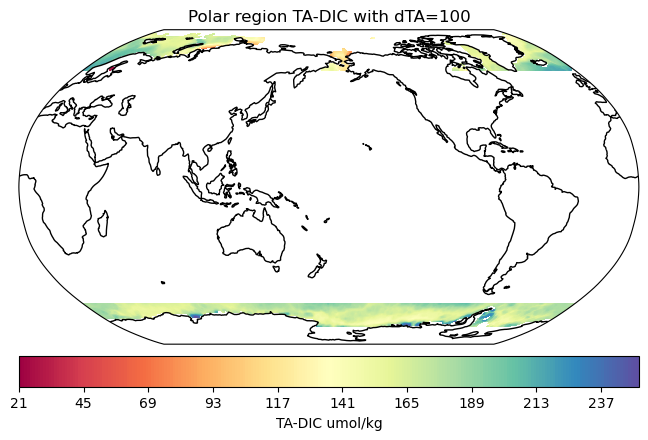

In [20]:
# QA check polar region selection
import cartopy.crs as ccrs
from matplotlib.colors import TwoSlopeNorm
plt.figure(figsize=(8, 5))
X = np.squeeze(ds_dict['x'])
Y = np.squeeze(ds_dict['y'])
Z = ds_dict['alkstar_polar_dTA100'][0,:,:].copy()
# Z = ds_dict_T['alkstar_polar'][:,0].copy()
# Z = np.reshape(Z,(NX,NY)).transpose(1,0)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines()
plt.title(r'Polar region TA-DIC with dTA=100')
plt.contourf(X,Y,Z,cmap='Spectral',levels=256,transform=ccrs.PlateCarree());
plt.colorbar(orientation="horizontal", pad=0.03,label=r'TA-DIC umol/kg');

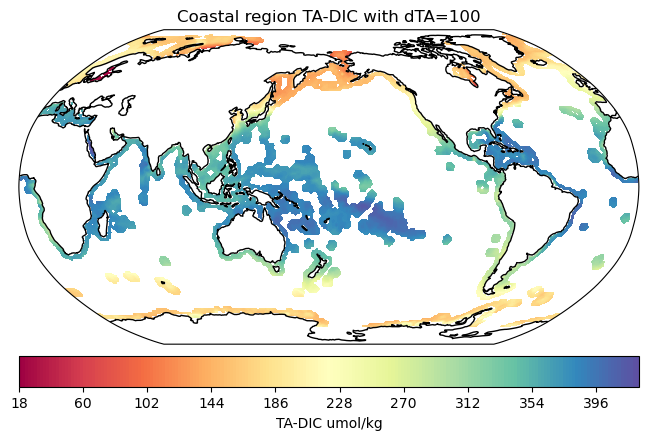

In [21]:
# QA check coastal region selection
import cartopy.crs as ccrs
from matplotlib.colors import TwoSlopeNorm
plt.figure(figsize=(8, 5))
X = np.squeeze(ds_dict['x'])
Y = np.squeeze(ds_dict['y'])
Z = ds_dict['alkstar_coastal_dTA100'][0,:,:].copy()
# Z = ds_dict_T['alkstar_polar'][:,0].copy()
# Z = np.reshape(Z,(NX,NY)).transpose(1,0)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines()
plt.title(r'Coastal region TA-DIC with dTA=100')
plt.contourf(X,Y,Z,cmap='Spectral',levels=256,transform=ccrs.PlateCarree());
plt.colorbar(orientation="horizontal", pad=0.03,label=r'TA-DIC umol/kg');

In [22]:
# define functions for weighted mean and standard deviations of a vector

def weighted_mean(data, weights):
    """
    weighted mean
    # Example usage
    data = np.array([1, 2, 3, 4, 5])
    weights = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
    wmean = weighted_mean(data, weights)
    print(f"Weighted Mean: {wmean}")
    """
    import numpy as np
    import sys
    ctrl = data.ndim==1 and weights.ndim==1
    if not ctrl:
      print('Check data and weights: they need to be vectors with one dimension!','\n')
      sys.exit()
    idx = np.where(~np.isnan(data) & ~np.isnan(weights))[0]
    result = np.average(data[idx], weights=weights[idx])
    return result

def weighted_std(data, weights):
    """
    weighted standard deviation
    # Example usage
    data = np.array([1, 2, 3, 4, 5])
    weights = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
    wstd = weighted_std(data, weights)
    print(f"Weighted Mean: {wstd}")
    """
    import numpy as np
    import sys
    ctrl = data.ndim==1 and weights.ndim==1
    if not ctrl:
      print('Check data and weights: they need to be vectors with one dimension!','\n')
      sys.exit()
    idx = np.where(~np.isnan(data) & ~np.isnan(weights))[0]
    mean = weighted_mean(data[idx], weights[idx])
    variance = np.average((data[idx] - mean)**2, weights=weights[idx])
    return np.sqrt(variance)

In [23]:
# QA check
i=0
x = ds_dict_T['alkstar_global_dTA100'][:,i].copy()
nnn(x)
area = ds_dict_T['area'].copy()
area = np.squeeze(np.transpose(area))
w = area
nnn(w)
idx = np.where(~np.isnan(x) & ~np.isnan(w))[0]
print(nnn(x[idx]))
print(nnn(w[idx]))


36627
36627


In [24]:
# define the function to solve for time-series of area-weighted TA, DIC, and alkstar
def find_wmean(i):

    for i_dTA in range(4):

        if i_dTA==0:
            # unperturbed
            if region == 'global':
                talk = ds_dict_T['talk_global_dTA0'][:,i].copy()
                dic = ds_dict_T['dic_global_dTA0'][:,i].copy()
                alkstar = ds_dict_T['alkstar_global_dTA0'][:,i].copy()
                omara = ds_dict_T['omara_global_dTA0'][:,i].copy()
                co3 = ds_dict_T['co3_global_dTA0'][:,i].copy()
                phtot = ds_dict_T['phtot_global_dTA0'][:,i].copy()
            elif region == 'coastal':
                talk = ds_dict_T['talk_coastal_dTA0'][:,i].copy()
                dic = ds_dict_T['dic_coastal_dTA0'][:,i].copy()
                alkstar = ds_dict_T['alkstar_coastal_dTA0'][:,i].copy()
                omara = ds_dict_T['omara_coastal_dTA0'][:,i].copy()
                co3 = ds_dict_T['co3_coastal_dTA0'][:,i].copy()
                phtot = ds_dict_T['phtot_coastal_dTA0'][:,i].copy()
            elif region == 'polar':
                talk = ds_dict_T['talk_polar_dTA0'][:,i].copy()
                dic = ds_dict_T['dic_polar_dTA0'][:,i].copy()
                alkstar = ds_dict_T['alkstar_polar_dTA0'][:,i].copy()
                omara = ds_dict_T['omara_polar_dTA0'][:,i].copy()
                co3 = ds_dict_T['co3_polar_dTA0'][:,i].copy()
                phtot = ds_dict_T['phtot_polar_dTA0'][:,i].copy()
        elif i_dTA==1:
            # dTA=10
            if region == 'global':
                talk = ds_dict_T['talk_global_dTA10'][:,i].copy()
                dic = ds_dict_T['dic_global_dTA10'][:,i].copy()
                alkstar = ds_dict_T['alkstar_global_dTA10'][:,i].copy()
                omara = ds_dict_T['omara_global_dTA10'][:,i].copy()
                co3 = ds_dict_T['co3_global_dTA10'][:,i].copy()
                phtot = ds_dict_T['phtot_global_dTA10'][:,i].copy()
            elif region == 'coastal':
                talk = ds_dict_T['talk_coastal_dTA10'][:,i].copy()
                dic = ds_dict_T['dic_coastal_dTA10'][:,i].copy()
                alkstar = ds_dict_T['alkstar_coastal_dTA10'][:,i].copy()
                omara = ds_dict_T['omara_coastal_dTA10'][:,i].copy()
                co3 = ds_dict_T['co3_coastal_dTA10'][:,i].copy()
                phtot = ds_dict_T['phtot_coastal_dTA10'][:,i].copy()
            elif region == 'polar':
                talk = ds_dict_T['talk_polar_dTA10'][:,i].copy()
                dic = ds_dict_T['dic_polar_dTA10'][:,i].copy()
                alkstar = ds_dict_T['alkstar_polar_dTA10'][:,i].copy()
                omara = ds_dict_T['omara_polar_dTA10'][:,i].copy()
                co3 = ds_dict_T['co3_polar_dTA10'][:,i].copy()
                phtot = ds_dict_T['phtot_polar_dTA10'][:,i].copy()
        elif i_dTA==2:
            # dTA=50
            if region == 'global':
                talk = ds_dict_T['talk_global_dTA50'][:,i].copy()
                dic = ds_dict_T['dic_global_dTA50'][:,i].copy()
                alkstar = ds_dict_T['alkstar_global_dTA50'][:,i].copy()
                omara = ds_dict_T['omara_global_dTA50'][:,i].copy()
                co3 = ds_dict_T['co3_global_dTA50'][:,i].copy()
                phtot = ds_dict_T['phtot_global_dTA50'][:,i].copy()
            elif region == 'coastal':
                talk = ds_dict_T['talk_coastal_dTA50'][:,i].copy()
                dic = ds_dict_T['dic_coastal_dTA50'][:,i].copy()
                alkstar = ds_dict_T['alkstar_coastal_dTA50'][:,i].copy()
                omara = ds_dict_T['omara_coastal_dTA50'][:,i].copy()
                co3 = ds_dict_T['co3_coastal_dTA50'][:,i].copy()
                phtot = ds_dict_T['phtot_coastal_dTA50'][:,i].copy()
            elif region == 'polar':
                talk = ds_dict_T['talk_polar_dTA50'][:,i].copy()
                dic = ds_dict_T['dic_polar_dTA50'][:,i].copy()
                alkstar = ds_dict_T['alkstar_polar_dTA50'][:,i].copy()
                omara = ds_dict_T['omara_polar_dTA50'][:,i].copy()
                co3 = ds_dict_T['co3_polar_dTA50'][:,i].copy()
                phtot = ds_dict_T['phtot_polar_dTA50'][:,i].copy()
        elif i_dTA==3:
            # dTA=100
            if region == 'global':
                talk = ds_dict_T['talk_global_dTA100'][:,i].copy()
                dic = ds_dict_T['dic_global_dTA100'][:,i].copy()
                alkstar = ds_dict_T['alkstar_global_dTA100'][:,i].copy()
                omara = ds_dict_T['omara_global_dTA100'][:,i].copy()
                co3 = ds_dict_T['co3_global_dTA100'][:,i].copy()
                phtot = ds_dict_T['phtot_global_dTA100'][:,i].copy()
            elif region == 'coastal':
                talk = ds_dict_T['talk_coastal_dTA100'][:,i].copy()
                dic = ds_dict_T['dic_coastal_dTA100'][:,i].copy()
                alkstar = ds_dict_T['alkstar_coastal_dTA100'][:,i].copy()
                omara = ds_dict_T['omara_coastal_dTA100'][:,i].copy()
                co3 = ds_dict_T['co3_coastal_dTA100'][:,i].copy()
                phtot = ds_dict_T['phtot_coastal_dTA100'][:,i].copy()
            elif region == 'polar':
                talk = ds_dict_T['talk_polar_dTA100'][:,i].copy()
                dic = ds_dict_T['dic_polar_dTA100'][:,i].copy()
                alkstar = ds_dict_T['alkstar_polar_dTA100'][:,i].copy()
                omara = ds_dict_T['omara_polar_dTA100'][:,i].copy()
                co3 = ds_dict_T['co3_polar_dTA100'][:,i].copy()
                phtot = ds_dict_T['phtot_polar_dTA100'][:,i].copy()

        area = ds_dict_T['area'].copy()
        area = np.squeeze(np.transpose(area))

        if i_dTA==0:
            # unperturbed
            wmean_talk_dTA0 = weighted_mean(talk,area)
            wmean_dic_dTA0 = weighted_mean(dic,area)
            wmean_alkstar_dTA0 = weighted_mean(alkstar,area)
            wmean_omara_dTA0 = weighted_mean(omara,area)
            wmean_co3_dTA0 = weighted_mean(co3,area)
            wmean_phtot_dTA0 = weighted_mean(phtot,area)
        elif i_dTA==1:
            # dTA=10
            wmean_talk_dTA10 = weighted_mean(talk,area)
            wmean_dic_dTA10 = weighted_mean(dic,area)
            wmean_alkstar_dTA10 = weighted_mean(alkstar,area)
            wmean_omara_dTA10 = weighted_mean(omara,area)
            wmean_co3_dTA10 = weighted_mean(co3,area)
            wmean_phtot_dTA10 = weighted_mean(phtot,area)
        elif i_dTA==2:
            # dTA=50
            wmean_talk_dTA50 = weighted_mean(talk,area)
            wmean_dic_dTA50 = weighted_mean(dic,area)
            wmean_alkstar_dTA50 = weighted_mean(alkstar,area)
            wmean_omara_dTA50 = weighted_mean(omara,area)
            wmean_co3_dTA50 = weighted_mean(co3,area)
            wmean_phtot_dTA50 = weighted_mean(phtot,area)
        elif i_dTA==3:
            # dTA=100
            wmean_talk_dTA100 = weighted_mean(talk,area)
            wmean_dic_dTA100 = weighted_mean(dic,area)
            wmean_alkstar_dTA100 = weighted_mean(alkstar,area)
            wmean_omara_dTA100 = weighted_mean(omara,area)
            wmean_co3_dTA100 = weighted_mean(co3,area)
            wmean_phtot_dTA100 = weighted_mean(phtot,area)

    output = {
        'i': i,
        'wmean_talk_dTA0': wmean_talk_dTA0,
        'wmean_dic_dTA0': wmean_dic_dTA0,
        'wmean_alkstar_dTA0': wmean_alkstar_dTA0,
        'wmean_omara_dTA0': wmean_omara_dTA0,
        'wmean_co3_dTA0': wmean_co3_dTA0,
        'wmean_phtot_dTA0': wmean_phtot_dTA0,
        'wmean_talk_dTA10': wmean_talk_dTA10,
        'wmean_dic_dTA10': wmean_dic_dTA10,
        'wmean_alkstar_dTA10': wmean_alkstar_dTA10,
        'wmean_omara_dTA10': wmean_omara_dTA10,
        'wmean_co3_dTA10': wmean_co3_dTA10,
        'wmean_phtot_dTA10': wmean_phtot_dTA10,
        'wmean_talk_dTA50': wmean_talk_dTA50,
        'wmean_dic_dTA50': wmean_dic_dTA50,
        'wmean_alkstar_dTA50': wmean_alkstar_dTA50,
        'wmean_omara_dTA50': wmean_omara_dTA50,
        'wmean_co3_dTA50': wmean_co3_dTA50,
        'wmean_phtot_dTA50': wmean_phtot_dTA50,
        'wmean_talk_dTA100': wmean_talk_dTA100,
        'wmean_dic_dTA100': wmean_dic_dTA100,
        'wmean_alkstar_dTA100': wmean_alkstar_dTA100,
        'wmean_omara_dTA100': wmean_omara_dTA100,
        'wmean_co3_dTA100': wmean_co3_dTA100,
        'wmean_phtot_dTA100': wmean_phtot_dTA100
        }
    return output

In [25]:
# initialize output arrays for area-weighted means

# # unperturbed
# talk
ds_dict["talk_global_wmean_dTA0"] = np.full((NT), np.nan)
ds_dict["talk_coastal_wmean_dTA0"] = np.full((NT), np.nan)
ds_dict["talk_polar_wmean_dTA0"] = np.full((NT), np.nan)
# dic
ds_dict["dic_global_wmean_dTA0"] = np.full((NT), np.nan)
ds_dict["dic_coastal_wmean_dTA0"] = np.full((NT), np.nan)
ds_dict["dic_polar_wmean_dTA0"] = np.full((NT), np.nan)
# alkstar
ds_dict["alkstar_global_wmean_dTA0"] = np.full((NT), np.nan)
ds_dict["alkstar_coastal_wmean_dTA0"] = np.full((NT), np.nan)
ds_dict["alkstar_polar_wmean_dTA0"] = np.full((NT), np.nan)
# omara
ds_dict["omara_global_wmean_dTA0"] = np.full((NT), np.nan)
ds_dict["omara_coastal_wmean_dTA0"] = np.full((NT), np.nan)
ds_dict["omara_polar_wmean_dTA0"] = np.full((NT), np.nan)
# co3
ds_dict["co3_global_wmean_dTA0"] = np.full((NT), np.nan)
ds_dict["co3_coastal_wmean_dTA0"] = np.full((NT), np.nan)
ds_dict["co3_polar_wmean_dTA0"] = np.full((NT), np.nan)
# phtot
ds_dict["phtot_global_wmean_dTA0"] = np.full((NT), np.nan)
ds_dict["phtot_coastal_wmean_dTA0"] = np.full((NT), np.nan)
ds_dict["phtot_polar_wmean_dTA0"] = np.full((NT), np.nan)

# # dTA=10
# talk
ds_dict["talk_global_wmean_dTA10"] = np.full((NT), np.nan)
ds_dict["talk_coastal_wmean_dTA10"] = np.full((NT), np.nan)
ds_dict["talk_polar_wmean_dTA10"] = np.full((NT), np.nan)
# dic
ds_dict["dic_global_wmean_dTA10"] = np.full((NT), np.nan)
ds_dict["dic_coastal_wmean_dTA10"] = np.full((NT), np.nan)
ds_dict["dic_polar_wmean_dTA10"] = np.full((NT), np.nan)
# alkstar
ds_dict["alkstar_global_wmean_dTA10"] = np.full((NT), np.nan)
ds_dict["alkstar_coastal_wmean_dTA10"] = np.full((NT), np.nan)
ds_dict["alkstar_polar_wmean_dTA10"] = np.full((NT), np.nan)
# omara
ds_dict["omara_global_wmean_dTA10"] = np.full((NT), np.nan)
ds_dict["omara_coastal_wmean_dTA10"] = np.full((NT), np.nan)
ds_dict["omara_polar_wmean_dTA10"] = np.full((NT), np.nan)
# co3
ds_dict["co3_global_wmean_dTA10"] = np.full((NT), np.nan)
ds_dict["co3_coastal_wmean_dTA10"] = np.full((NT), np.nan)
ds_dict["co3_polar_wmean_dTA10"] = np.full((NT), np.nan)
# phtot
ds_dict["phtot_global_wmean_dTA10"] = np.full((NT), np.nan)
ds_dict["phtot_coastal_wmean_dTA10"] = np.full((NT), np.nan)
ds_dict["phtot_polar_wmean_dTA10"] = np.full((NT), np.nan)

# # dTA=50
# talk
ds_dict["talk_global_wmean_dTA50"] = np.full((NT), np.nan)
ds_dict["talk_coastal_wmean_dTA50"] = np.full((NT), np.nan)
ds_dict["talk_polar_wmean_dTA50"] = np.full((NT), np.nan)
# dic
ds_dict["dic_global_wmean_dTA50"] = np.full((NT), np.nan)
ds_dict["dic_coastal_wmean_dTA50"] = np.full((NT), np.nan)
ds_dict["dic_polar_wmean_dTA50"] = np.full((NT), np.nan)
# alkstar
ds_dict["alkstar_global_wmean_dTA50"] = np.full((NT), np.nan)
ds_dict["alkstar_coastal_wmean_dTA50"] = np.full((NT), np.nan)
ds_dict["alkstar_polar_wmean_dTA50"] = np.full((NT), np.nan)
# omara
ds_dict["omara_global_wmean_dTA50"] = np.full((NT), np.nan)
ds_dict["omara_coastal_wmean_dTA50"] = np.full((NT), np.nan)
ds_dict["omara_polar_wmean_dTA50"] = np.full((NT), np.nan)
# co3
ds_dict["co3_global_wmean_dTA50"] = np.full((NT), np.nan)
ds_dict["co3_coastal_wmean_dTA50"] = np.full((NT), np.nan)
ds_dict["co3_polar_wmean_dTA50"] = np.full((NT), np.nan)
# phtot
ds_dict["phtot_global_wmean_dTA50"] = np.full((NT), np.nan)
ds_dict["phtot_coastal_wmean_dTA50"] = np.full((NT), np.nan)
ds_dict["phtot_polar_wmean_dTA50"] = np.full((NT), np.nan)

# # dTA=100
# talk
ds_dict["talk_global_wmean_dTA100"] = np.full((NT), np.nan)
ds_dict["talk_coastal_wmean_dTA100"] = np.full((NT), np.nan)
ds_dict["talk_polar_wmean_dTA100"] = np.full((NT), np.nan)
# dic
ds_dict["dic_global_wmean_dTA100"] = np.full((NT), np.nan)
ds_dict["dic_coastal_wmean_dTA100"] = np.full((NT), np.nan)
ds_dict["dic_polar_wmean_dTA100"] = np.full((NT), np.nan)
# alkstar
ds_dict["alkstar_global_wmean_dTA100"] = np.full((NT), np.nan)
ds_dict["alkstar_coastal_wmean_dTA100"] = np.full((NT), np.nan)
ds_dict["alkstar_polar_wmean_dTA100"] = np.full((NT), np.nan)
# omara
ds_dict["omara_global_wmean_dTA100"] = np.full((NT), np.nan)
ds_dict["omara_coastal_wmean_dTA100"] = np.full((NT), np.nan)
ds_dict["omara_polar_wmean_dTA100"] = np.full((NT), np.nan)
# co3
ds_dict["co3_global_wmean_dTA100"] = np.full((NT), np.nan)
ds_dict["co3_coastal_wmean_dTA100"] = np.full((NT), np.nan)
ds_dict["co3_polar_wmean_dTA100"] = np.full((NT), np.nan)
# phtot
ds_dict["phtot_global_wmean_dTA100"] = np.full((NT), np.nan)
ds_dict["phtot_coastal_wmean_dTA100"] = np.full((NT), np.nan)
ds_dict["phtot_polar_wmean_dTA100"] = np.full((NT), np.nan)

In [26]:
# global area-weighted means
tic()
print('Computing global area-weighted means, please wait ...')
region = 'global'
for i in range(NT):
    result = find_wmean(i)
    # unperturbed
    ds_dict["talk_global_wmean_dTA0"][i]= result["wmean_talk_dTA0"]
    ds_dict["dic_global_wmean_dTA0"][i]= result["wmean_dic_dTA0"]
    ds_dict["alkstar_global_wmean_dTA0"][i]= result["wmean_alkstar_dTA0"]
    ds_dict["omara_global_wmean_dTA0"][i]= result["wmean_omara_dTA0"]
    ds_dict["co3_global_wmean_dTA0"][i]= result["wmean_co3_dTA0"]
    ds_dict["phtot_global_wmean_dTA0"][i]= result["wmean_phtot_dTA0"]
    # dTA=10
    ds_dict["talk_global_wmean_dTA10"][i]= result["wmean_talk_dTA10"]
    ds_dict["dic_global_wmean_dTA10"][i]= result["wmean_dic_dTA10"]
    ds_dict["alkstar_global_wmean_dTA10"][i]= result["wmean_alkstar_dTA10"]
    ds_dict["omara_global_wmean_dTA10"][i]= result["wmean_omara_dTA10"]
    ds_dict["co3_global_wmean_dTA10"][i]= result["wmean_co3_dTA10"]
    ds_dict["phtot_global_wmean_dTA10"][i]= result["wmean_phtot_dTA10"]
    # dTA=50
    ds_dict["talk_global_wmean_dTA50"][i]= result["wmean_talk_dTA50"]
    ds_dict["dic_global_wmean_dTA50"][i]= result["wmean_dic_dTA50"]
    ds_dict["alkstar_global_wmean_dTA50"][i]= result["wmean_alkstar_dTA50"]
    ds_dict["omara_global_wmean_dTA50"][i]= result["wmean_omara_dTA50"]
    ds_dict["co3_global_wmean_dTA50"][i]= result["wmean_co3_dTA50"]
    ds_dict["phtot_global_wmean_dTA50"][i]= result["wmean_phtot_dTA50"]
    # dTA=100
    ds_dict["talk_global_wmean_dTA100"][i]= result["wmean_talk_dTA100"]
    ds_dict["dic_global_wmean_dTA100"][i]= result["wmean_dic_dTA100"]
    ds_dict["alkstar_global_wmean_dTA100"][i]= result["wmean_alkstar_dTA100"]
    ds_dict["omara_global_wmean_dTA100"][i]= result["wmean_omara_dTA100"]
    ds_dict["co3_global_wmean_dTA100"][i]= result["wmean_co3_dTA100"]
    ds_dict["phtot_global_wmean_dTA100"][i]= result["wmean_phtot_dTA100"]
    # print(i,result["wmean_talk"]) 
print('Done')
toc()

# polar area-weighted means
tic()
print('Computing polar area-weighted means, please wait ...')
region = 'polar'
for i in range(NT):
    result = find_wmean(i)
    # unperturbed
    ds_dict["talk_polar_wmean_dTA0"][i]= result["wmean_talk_dTA0"]
    ds_dict["dic_polar_wmean_dTA0"][i]= result["wmean_dic_dTA0"]
    ds_dict["alkstar_polar_wmean_dTA0"][i]= result["wmean_alkstar_dTA0"]
    ds_dict["omara_polar_wmean_dTA0"][i]= result["wmean_omara_dTA0"]
    ds_dict["co3_polar_wmean_dTA0"][i]= result["wmean_co3_dTA0"]
    ds_dict["phtot_polar_wmean_dTA0"][i]= result["wmean_phtot_dTA0"]
    # dTA=10
    ds_dict["talk_polar_wmean_dTA10"][i]= result["wmean_talk_dTA10"]
    ds_dict["dic_polar_wmean_dTA10"][i]= result["wmean_dic_dTA10"]
    ds_dict["alkstar_polar_wmean_dTA10"][i]= result["wmean_alkstar_dTA10"]
    ds_dict["omara_polar_wmean_dTA10"][i]= result["wmean_omara_dTA10"]
    ds_dict["co3_polar_wmean_dTA10"][i]= result["wmean_co3_dTA10"]
    ds_dict["phtot_polar_wmean_dTA10"][i]= result["wmean_phtot_dTA10"]
    # dTA=50
    ds_dict["talk_polar_wmean_dTA50"][i]= result["wmean_talk_dTA50"]
    ds_dict["dic_polar_wmean_dTA50"][i]= result["wmean_dic_dTA50"]
    ds_dict["alkstar_polar_wmean_dTA50"][i]= result["wmean_alkstar_dTA50"]
    ds_dict["omara_polar_wmean_dTA50"][i]= result["wmean_omara_dTA50"]
    ds_dict["co3_polar_wmean_dTA50"][i]= result["wmean_co3_dTA50"]
    ds_dict["phtot_polar_wmean_dTA50"][i]= result["wmean_phtot_dTA50"]
    # dTA=100
    ds_dict["talk_polar_wmean_dTA100"][i]= result["wmean_talk_dTA100"]
    ds_dict["dic_polar_wmean_dTA100"][i]= result["wmean_dic_dTA100"]
    ds_dict["alkstar_polar_wmean_dTA100"][i]= result["wmean_alkstar_dTA100"]
    ds_dict["omara_polar_wmean_dTA100"][i]= result["wmean_omara_dTA100"]
    ds_dict["co3_polar_wmean_dTA100"][i]= result["wmean_co3_dTA100"]
    ds_dict["phtot_polar_wmean_dTA100"][i]= result["wmean_phtot_dTA100"]
    # print(i,result["wmean_talk"]) 
print('Done')
toc()

# coastal area-weighted means
tic()
print('Computing coastal area-weighted means, please wait ...')
region = 'coastal'
for i in range(NT):
    result = find_wmean(i)
    # unperturbed
    ds_dict["talk_coastal_wmean_dTA0"][i]= result["wmean_talk_dTA0"]
    ds_dict["dic_coastal_wmean_dTA0"][i]= result["wmean_dic_dTA0"]
    ds_dict["alkstar_coastal_wmean_dTA0"][i]= result["wmean_alkstar_dTA0"]
    ds_dict["omara_coastal_wmean_dTA0"][i]= result["wmean_omara_dTA0"]
    ds_dict["co3_coastal_wmean_dTA0"][i]= result["wmean_co3_dTA0"]
    ds_dict["phtot_coastal_wmean_dTA0"][i]= result["wmean_phtot_dTA0"]
    # dTA=10
    ds_dict["talk_coastal_wmean_dTA10"][i]= result["wmean_talk_dTA10"]
    ds_dict["dic_coastal_wmean_dTA10"][i]= result["wmean_dic_dTA10"]
    ds_dict["alkstar_coastal_wmean_dTA10"][i]= result["wmean_alkstar_dTA10"]
    ds_dict["omara_coastal_wmean_dTA10"][i]= result["wmean_omara_dTA10"]
    ds_dict["co3_coastal_wmean_dTA10"][i]= result["wmean_co3_dTA10"]
    ds_dict["phtot_coastal_wmean_dTA10"][i]= result["wmean_phtot_dTA10"]
    # dTA=50
    ds_dict["talk_coastal_wmean_dTA50"][i]= result["wmean_talk_dTA50"]
    ds_dict["dic_coastal_wmean_dTA50"][i]= result["wmean_dic_dTA50"]
    ds_dict["alkstar_coastal_wmean_dTA50"][i]= result["wmean_alkstar_dTA50"]
    ds_dict["omara_coastal_wmean_dTA50"][i]= result["wmean_omara_dTA50"]
    ds_dict["co3_coastal_wmean_dTA50"][i]= result["wmean_co3_dTA50"]
    ds_dict["phtot_coastal_wmean_dTA50"][i]= result["wmean_phtot_dTA50"]
    # dTA=100
    ds_dict["talk_coastal_wmean_dTA100"][i]= result["wmean_talk_dTA100"]
    ds_dict["dic_coastal_wmean_dTA100"][i]= result["wmean_dic_dTA100"]
    ds_dict["alkstar_coastal_wmean_dTA100"][i]= result["wmean_alkstar_dTA100"]
    ds_dict["omara_coastal_wmean_dTA100"][i]= result["wmean_omara_dTA100"]
    ds_dict["co3_coastal_wmean_dTA100"][i]= result["wmean_co3_dTA100"]
    ds_dict["phtot_coastal_wmean_dTA100"][i]= result["wmean_phtot_dTA100"]
    # print(i,result["wmean_talk"]) 
print('Done')
toc()

Computing global area-weighted means, please wait ...
Done
Elapsed time: 6.123346 seconds.

Computing polar area-weighted means, please wait ...
Done
Elapsed time: 5.202999 seconds.

Computing coastal area-weighted means, please wait ...
Done
Elapsed time: 6.356293 seconds.



In [27]:
# define function for moving average
def moving_average(x, w=12):
    """
    moving mean of vector x with window size w
    with default window size w=12
    example:
    a = np.arange(20)
    a_n4 = moving_average(a, 4)
    print('a_n4= ',a_n4, a_n4.shape)
    # a_n4=  [ 1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5
    # 15.5 16.5 17.5] (17,)    
    """
    import numpy as np
    import sys
    ctrl = np.isreal(x).all() and (not np.isnan(x).any()) and (not np.isinf(x).any()) and x.ndim==1
    if not ctrl:
      print('Check x: it needs be a vector of real numbers with no infinite or nan values!','\n')
      sys.exit()
    return np.convolve(x, np.ones(w), 'valid') / w

# Time series of TA-DIC, pH, and Ωar

## Global 12-month moving averages

<>:108: SyntaxWarning: invalid escape sequence '\D'
<>:160: SyntaxWarning: invalid escape sequence '\D'
<>:108: SyntaxWarning: invalid escape sequence '\D'
<>:160: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_23902/275293126.py:108: SyntaxWarning: invalid escape sequence '\D'
  ax['B'].text(1995, y_pos, f'slope = {10*slope:.3f} $\Delta$pH per decade',
/tmp/ipykernel_23902/275293126.py:160: SyntaxWarning: invalid escape sequence '\D'
  ax['C'].text(1995, y_pos, f'slope = {10*slope:.3f} $\Delta\Omega$ar per decade',


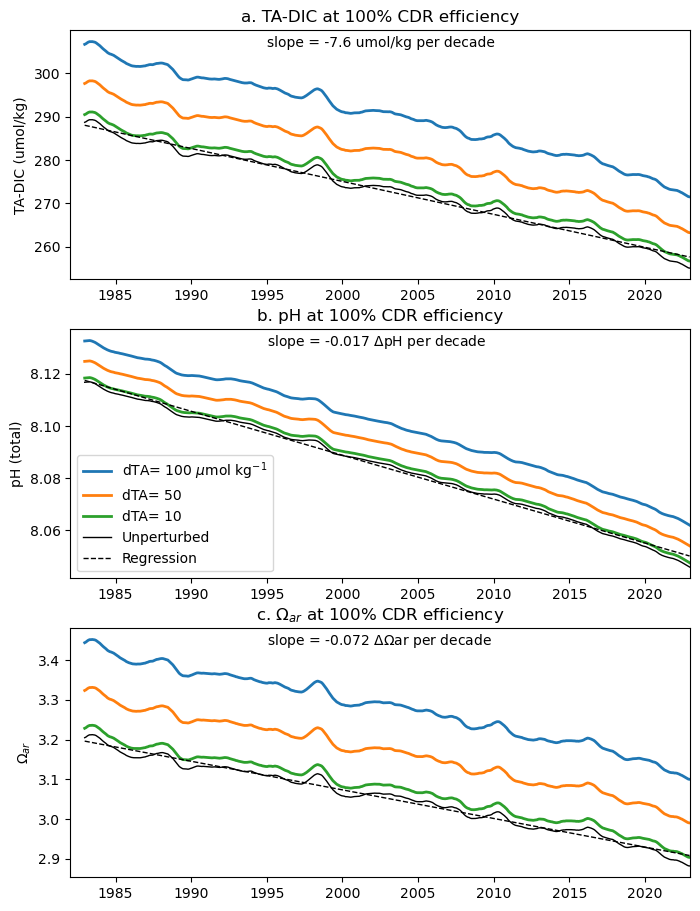

In [28]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplot_mosaic(
    '''
    A
    B
    C
    ''',
    figsize = (8, 11)
)
delta_treatment = np.full((3,3), np.nan) # % n_vars (TA:DIC, pH, OmegaAr) x n_deltaTA (1,10,100)
slope_control = np.full((3), np.nan)	 # % n_vars (TA:DIC, pH, OmegaAr) x 1
year_shift = np.full((3,3), np.nan)      # % n_vars (TA:DIC, pH, OmegaAr) x n_deltaTA (1,10,100)
mean_control = np.full((3), np.nan)      # % n_vars (hal, str, mer) x 1
# - - -
# Plot at ['A']
#
x = np.squeeze(ds_dict["yearfrac"]).copy()
y0 = np.squeeze(ds_dict["alkstar_global_wmean_dTA0"]).copy()
y1 = np.squeeze(ds_dict["alkstar_global_wmean_dTA10"]).copy()
y2 = np.squeeze(ds_dict["alkstar_global_wmean_dTA50"]).copy()
y3 = np.squeeze(ds_dict["alkstar_global_wmean_dTA100"]).copy()
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
ax['A'].plot(x, y3, 
    label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y1, 
    label='dTA=10', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y0, 
    label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
ax['A'].plot(x, y_pred, 
    label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['A'].set_ylabel('TA-DIC (umol/kg)')
# ax['A'].legend(loc='lower left')
ax['A'].set_title('a. TA-DIC at 100% CDR efficiency')
ax['A'].set_xlim(1982, 2023)
y_min, y_max = ax['A'].get_ylim()
y_pos = y_min + 0.95 * (y_max - y_min)
ax['A'].text(1995, y_pos, f'slope = {10*slope:.1f} umol/kg per decade',
        fontsize=10, color='black', ha='left', va='center')
# % save for output to xls
mean_control[0] = np.nanmean(y0);
delta_treatment[0,0] = np.nanmean(y1-y0);
delta_treatment[0,1] = np.nanmean(y2-y0);
delta_treatment[0,2] = np.nanmean(y3-y0);
slope_control[0] = slope*10;
year_shift[0,0] = np.nanmean(y1-y0) / slope;
year_shift[0,1] = np.nanmean(y2-y0) / slope;
year_shift[0,2] = np.nanmean(y3-y0) / slope;
# - - -
# Plot at ['B']
#
x = np.squeeze(ds_dict["yearfrac"]).copy()
y0 = np.squeeze(ds_dict["phtot_global_wmean_dTA0"]).copy()
y1 = np.squeeze(ds_dict["phtot_global_wmean_dTA10"]).copy()
y2 = np.squeeze(ds_dict["phtot_global_wmean_dTA50"]).copy()
y3 = np.squeeze(ds_dict["phtot_global_wmean_dTA100"]).copy()
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
ax['B'].plot(x, y3, 
    label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y1, 
    label='dTA= 10', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y0, 
    label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
ax['B'].plot(x, y_pred, 
    label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['B'].set_ylabel('pH (total)')
ax['B'].legend(loc='lower left')
ax['B'].set_title('b. pH at 100% CDR efficiency')
ax['B'].set_xlim(1982, 2023)
y_min, y_max = ax['B'].get_ylim()
y_pos = y_min + 0.95 * (y_max - y_min)
ax['B'].text(1995, y_pos, f'slope = {10*slope:.3f} $\Delta$pH per decade',
        fontsize=10, color='black', ha='left', va='center')
# % save for output to xls
mean_control[1] = np.nanmean(y0);
delta_treatment[1,0] = np.nanmean(y1-y0);
delta_treatment[1,1] = np.nanmean(y2-y0);
delta_treatment[1,2] = np.nanmean(y3-y0);
slope_control[1] = slope*10;
year_shift[1,0] = np.nanmean(y1-y0) / slope;
year_shift[1,1] = np.nanmean(y2-y0) / slope;
year_shift[1,2] = np.nanmean(y3-y0) / slope;
# - - -
# Plot at ['C']
#
x = np.squeeze(ds_dict["yearfrac"]).copy()
y0 = np.squeeze(ds_dict["omara_global_wmean_dTA0"]).copy()
y1 = np.squeeze(ds_dict["omara_global_wmean_dTA10"]).copy()
y2 = np.squeeze(ds_dict["omara_global_wmean_dTA50"]).copy()
y3 = np.squeeze(ds_dict["omara_global_wmean_dTA100"]).copy()
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
ax['C'].plot(x, y3, 
    label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y1, 
    label='dTA= 10', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y0, 
    label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
ax['C'].plot(x, y_pred, 
    label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['C'].set_ylabel(r'$\Omega_{ar}$')
# ax['C'].legend(loc='lower left')
ax['C'].set_title(r'c. $\Omega_{ar}$ at 100% CDR efficiency')
ax['C'].set_xlim(1982, 2023);
y_min, y_max = ax['C'].get_ylim()
y_pos = y_min + 0.95 * (y_max - y_min)
ax['C'].text(1995, y_pos, f'slope = {10*slope:.3f} $\Delta\Omega$ar per decade',
        fontsize=10, color='black', ha='left', va='center')
# % save for output to xls
mean_control[2] = np.nanmean(y0);
delta_treatment[2,0] = np.nanmean(y1-y0);
delta_treatment[2,1] = np.nanmean(y2-y0);
delta_treatment[2,2] = np.nanmean(y3-y0);
slope_control[2] = slope*10;
year_shift[2,0] = np.nanmean(y1-y0) / slope;
year_shift[2,1] = np.nanmean(y2-y0) / slope;
year_shift[2,2] = np.nanmean(y3-y0) / slope;
# - - -

fig.savefig('Fig8_global_cdreff100_12mo_movmean_alkstar_phtot_omara_v20.png', format='png', dpi=300);

In [29]:
# mitigation time shift table
print('mean_control: \n',mean_control)      # % n_vars (TA:DIC, pH, OmegaAr) x 1
print('slope_control: \n',slope_control)	 # % n_vars (TA:DIC, pH, OmegaAr) x 1
print('delta_treatment: \n',delta_treatment) # % n_vars (TA:DIC, pH, OmegaAr) x n_deltaTA (1,10,100)
print('year_shift: \n',year_shift)      # % n_vars (TA:DIC, pH, OmegaAr) x n_deltaTA (1,10,100)

mean_control: 
 [272.82692478   8.0838129    3.0519959 ]
slope_control: 
 [-7.59583426 -0.01683941 -0.07197258]
delta_treatment: 
 [[1.71097975e+00 8.58584146e+00 1.72484224e+01]
 [1.62902720e-03 8.06822131e-03 1.59491812e-02]
 [2.26497542e-02 1.13840249e-01 2.29145100e-01]]
year_shift: 
 [[ -2.25252385 -11.30335564 -22.70773963]
 [ -0.96738972  -4.79127317  -9.4713421 ]
 [ -3.14699765 -15.81716923 -31.8378329 ]]


## Coastal 12-month moving averages

<>:108: SyntaxWarning: invalid escape sequence '\D'
<>:160: SyntaxWarning: invalid escape sequence '\D'
<>:108: SyntaxWarning: invalid escape sequence '\D'
<>:160: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_23902/1816129426.py:108: SyntaxWarning: invalid escape sequence '\D'
  ax['B'].text(1995, y_pos, f'slope = {10*slope:.3f} $\Delta$pH per decade',
/tmp/ipykernel_23902/1816129426.py:160: SyntaxWarning: invalid escape sequence '\D'
  ax['C'].text(1995, y_pos, f'slope = {10*slope:.3f} $\Delta\Omega$ar per decade',


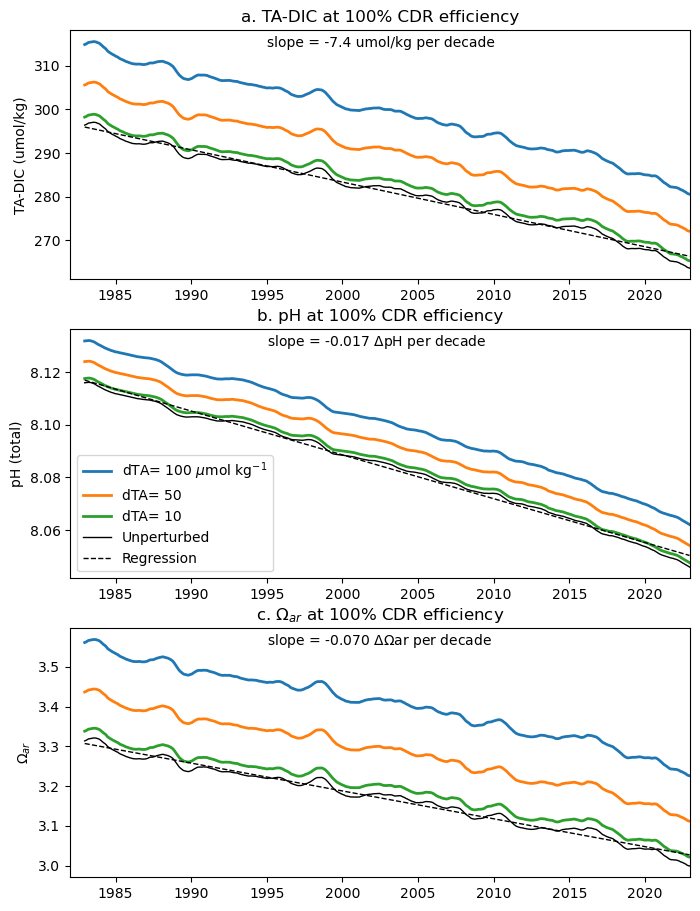

In [30]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplot_mosaic(
    '''
    A
    B
    C
    ''',
    figsize = (8, 11)
)
delta_treatment = np.full((3,3), np.nan) # % n_vars (TA:DIC, pH, OmegaAr) x n_deltaTA (1,10,100)
slope_control = np.full((3), np.nan)	 # % n_vars (TA:DIC, pH, OmegaAr) x 1
year_shift = np.full((3,3), np.nan)      # % n_vars (TA:DIC, pH, OmegaAr) x n_deltaTA (1,10,100)
mean_control = np.full((3), np.nan)      # % n_vars (hal, str, mer) x 1
# - - -
# Plot at ['A']
#
x = np.squeeze(ds_dict["yearfrac"]).copy()
y0 = np.squeeze(ds_dict["alkstar_coastal_wmean_dTA0"]).copy()
y1 = np.squeeze(ds_dict["alkstar_coastal_wmean_dTA10"]).copy()
y2 = np.squeeze(ds_dict["alkstar_coastal_wmean_dTA50"]).copy()
y3 = np.squeeze(ds_dict["alkstar_coastal_wmean_dTA100"]).copy()
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
ax['A'].plot(x, y3, 
    label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y1, 
    label='dTA=10', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y0, 
    label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
ax['A'].plot(x, y_pred, 
    label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['A'].set_ylabel('TA-DIC (umol/kg)')
# ax['A'].legend(loc='lower left')
ax['A'].set_title('a. TA-DIC at 100% CDR efficiency')
ax['A'].set_xlim(1982, 2023)
y_min, y_max = ax['A'].get_ylim()
y_pos = y_min + 0.95 * (y_max - y_min)
ax['A'].text(1995, y_pos, f'slope = {10*slope:.1f} umol/kg per decade',
        fontsize=10, color='black', ha='left', va='center')
# % save for output to xls
mean_control[0] = np.nanmean(y0);
delta_treatment[0,0] = np.nanmean(y1-y0);
delta_treatment[0,1] = np.nanmean(y2-y0);
delta_treatment[0,2] = np.nanmean(y3-y0);
slope_control[0] = slope*10;
year_shift[0,0] = np.nanmean(y1-y0) / slope;
year_shift[0,1] = np.nanmean(y2-y0) / slope;
year_shift[0,2] = np.nanmean(y3-y0) / slope;
# - - -
# Plot at ['B']
#
x = np.squeeze(ds_dict["yearfrac"]).copy()
y0 = np.squeeze(ds_dict["phtot_coastal_wmean_dTA0"]).copy()
y1 = np.squeeze(ds_dict["phtot_coastal_wmean_dTA10"]).copy()
y2 = np.squeeze(ds_dict["phtot_coastal_wmean_dTA50"]).copy()
y3 = np.squeeze(ds_dict["phtot_coastal_wmean_dTA100"]).copy()
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
ax['B'].plot(x, y3, 
    label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y1, 
    label='dTA= 10', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y0, 
    label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
ax['B'].plot(x, y_pred, 
    label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['B'].set_ylabel('pH (total)')
ax['B'].legend(loc='lower left')
ax['B'].set_title('b. pH at 100% CDR efficiency')
ax['B'].set_xlim(1982, 2023)
y_min, y_max = ax['B'].get_ylim()
y_pos = y_min + 0.95 * (y_max - y_min)
ax['B'].text(1995, y_pos, f'slope = {10*slope:.3f} $\Delta$pH per decade',
        fontsize=10, color='black', ha='left', va='center')
# % save for output to xls
mean_control[1] = np.nanmean(y0);
delta_treatment[1,0] = np.nanmean(y1-y0);
delta_treatment[1,1] = np.nanmean(y2-y0);
delta_treatment[1,2] = np.nanmean(y3-y0);
slope_control[1] = slope*10;
year_shift[1,0] = np.nanmean(y1-y0) / slope;
year_shift[1,1] = np.nanmean(y2-y0) / slope;
year_shift[1,2] = np.nanmean(y3-y0) / slope;
# - - -
# Plot at ['C']
#
x = np.squeeze(ds_dict["yearfrac"]).copy()
y0 = np.squeeze(ds_dict["omara_coastal_wmean_dTA0"]).copy()
y1 = np.squeeze(ds_dict["omara_coastal_wmean_dTA10"]).copy()
y2 = np.squeeze(ds_dict["omara_coastal_wmean_dTA50"]).copy()
y3 = np.squeeze(ds_dict["omara_coastal_wmean_dTA100"]).copy()
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
ax['C'].plot(x, y3, 
    label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y1, 
    label='dTA=10', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y0, 
    label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
ax['C'].plot(x, y_pred, 
    label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['C'].set_ylabel(r'$\Omega_{ar}$')
# ax['C'].legend(loc='lower left')
ax['C'].set_title(r'c. $\Omega_{ar}$ at 100% CDR efficiency')
ax['C'].set_xlim(1982, 2023);
y_min, y_max = ax['C'].get_ylim()
y_pos = y_min + 0.95 * (y_max - y_min)
ax['C'].text(1995, y_pos, f'slope = {10*slope:.3f} $\Delta\Omega$ar per decade',
        fontsize=10, color='black', ha='left', va='center')
# % save for output to xls
mean_control[2] = np.nanmean(y0);
delta_treatment[2,0] = np.nanmean(y1-y0);
delta_treatment[2,1] = np.nanmean(y2-y0);
delta_treatment[2,2] = np.nanmean(y3-y0);
slope_control[2] = slope*10;
year_shift[2,0] = np.nanmean(y1-y0) / slope;
year_shift[2,1] = np.nanmean(y2-y0) / slope;
year_shift[2,2] = np.nanmean(y3-y0) / slope;

# str_mean = f"{ds_dict["pco2_bio_1982_2022_mean"][j,i]:.1f}"
# str_amp = f"{ds_dict["pco2_bio_1982_2022_amplitude"][j,i]:.1f}"
# str_rmse = f"{ds_dict["pco2_bio_1982_2022_rmse"][j,i]:.1f}"
# str_rsq = f"{ds_dict["pco2_bio_1982_2022_adj_rsquared"][j,i]:.2f}"
# ax['B'].text(1983, -125, 'Mean: '+str_mean+', Amplitude: '+str_amp+', RMSE: '+str_rmse+' uatm'+', r-square: '+str_rsq,
#         fontsize=10, color='black', ha='left', va='center')
# ax['B'].axhline(y=0, color='k', linestyle=':')
# ax['B'].set_ylim(-140, 90)
# - - -

fig.savefig('Fig8_coastal_cdreff100_12mo_movmean_alkstar_phtot_omara_v20.png', format='png', dpi=300);

In [31]:
# mitigation time shift table
print('mean_control: \n',mean_control)      # % n_vars (TA:DIC, pH, OmegaAr) x 1
print('slope_control: \n',slope_control)	 # % n_vars (TA:DIC, pH, OmegaAr) x 1
print('delta_treatment: \n',delta_treatment) # % n_vars (TA:DIC, pH, OmegaAr) x n_deltaTA (1,10,100)
print('year_shift: \n',year_shift)      # % n_vars (TA:DIC, pH, OmegaAr) x n_deltaTA (1,10,100)

mean_control: 
 [281.15906554   8.08366372   3.16717485]
slope_control: 
 [-7.38993597 -0.01663382 -0.06995275]
delta_treatment: 
 [[1.75825033e+00 8.82248914e+00 1.77224489e+01]
 [1.63476765e-03 8.09582237e-03 1.60017669e-02]
 [2.34953740e-02 1.18082360e-01 2.37663550e-01]]
year_shift: 
 [[ -2.37924978 -11.93851925 -23.98187106]
 [ -0.98279732  -4.86708465  -9.62001767]
 [ -3.3587493  -16.88030357 -33.97487023]]


## Polar 12-month moving averages

<>:108: SyntaxWarning: invalid escape sequence '\D'
<>:160: SyntaxWarning: invalid escape sequence '\D'
<>:108: SyntaxWarning: invalid escape sequence '\D'
<>:160: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_23902/3526005474.py:108: SyntaxWarning: invalid escape sequence '\D'
  ax['B'].text(1995, y_pos, f'slope = {10*slope:.3f} $\Delta$pH per decade',
/tmp/ipykernel_23902/3526005474.py:160: SyntaxWarning: invalid escape sequence '\D'
  ax['C'].text(1995, y_pos, f'slope = {10*slope:.3f} $\Delta\Omega$ar per decade',


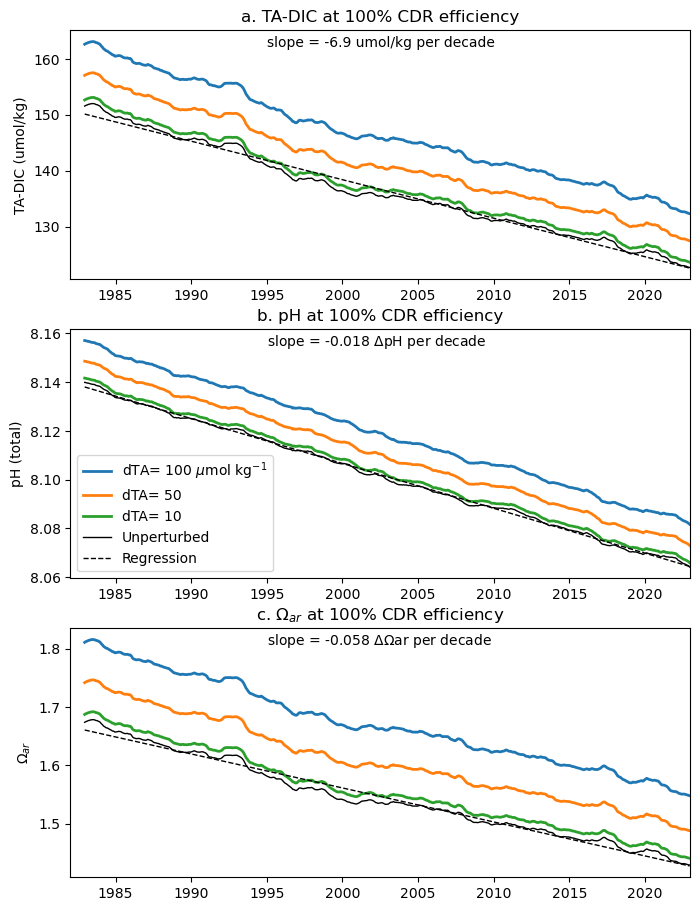

In [32]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplot_mosaic(
    '''
    A
    B
    C
    ''',
    figsize = (8, 11)
)
delta_treatment = np.full((3,3), np.nan) # % n_vars (TA:DIC, pH, OmegaAr) x n_deltaTA (1,10,100)
slope_control = np.full((3), np.nan)	 # % n_vars (TA:DIC, pH, OmegaAr) x 1
year_shift = np.full((3,3), np.nan)      # % n_vars (TA:DIC, pH, OmegaAr) x n_deltaTA (1,10,100)
mean_control = np.full((3), np.nan)      # % n_vars (hal, str, mer) x 1
# - - -
# Plot at ['A']
#
x = np.squeeze(ds_dict["yearfrac"]).copy()
y0 = np.squeeze(ds_dict["alkstar_polar_wmean_dTA0"]).copy()
y1 = np.squeeze(ds_dict["alkstar_polar_wmean_dTA10"]).copy()
y2 = np.squeeze(ds_dict["alkstar_polar_wmean_dTA50"]).copy()
y3 = np.squeeze(ds_dict["alkstar_polar_wmean_dTA100"]).copy()
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
ax['A'].plot(x, y3, 
    label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y1, 
    label='dTA=10', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y0, 
    label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
ax['A'].plot(x, y_pred, 
    label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['A'].set_ylabel('TA-DIC (umol/kg)')
# ax['A'].legend(loc='lower left')
ax['A'].set_title('a. TA-DIC at 100% CDR efficiency')
ax['A'].set_xlim(1982, 2023)
y_min, y_max = ax['A'].get_ylim()
y_pos = y_min + 0.95 * (y_max - y_min)
ax['A'].text(1995, y_pos, f'slope = {10*slope:.1f} umol/kg per decade',
        fontsize=10, color='black', ha='left', va='center')
# % save for output to xls
mean_control[0] = np.nanmean(y0);
delta_treatment[0,0] = np.nanmean(y1-y0);
delta_treatment[0,1] = np.nanmean(y2-y0);
delta_treatment[0,2] = np.nanmean(y3-y0);
slope_control[0] = slope*10;
year_shift[0,0] = np.nanmean(y1-y0) / slope;
year_shift[0,1] = np.nanmean(y2-y0) / slope;
year_shift[0,2] = np.nanmean(y3-y0) / slope;
# - - -
# Plot at ['B']
#
x = np.squeeze(ds_dict["yearfrac"]).copy()
y0 = np.squeeze(ds_dict["phtot_polar_wmean_dTA0"]).copy()
y1 = np.squeeze(ds_dict["phtot_polar_wmean_dTA10"]).copy()
y2 = np.squeeze(ds_dict["phtot_polar_wmean_dTA50"]).copy()
y3 = np.squeeze(ds_dict["phtot_polar_wmean_dTA100"]).copy()
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
ax['B'].plot(x, y3, 
    label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y1, 
    label='dTA= 10', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y0, 
    label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
ax['B'].plot(x, y_pred, 
    label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['B'].set_ylabel('pH (total)')
ax['B'].legend(loc='lower left')
ax['B'].set_title('b. pH at 100% CDR efficiency')
ax['B'].set_xlim(1982, 2023)
y_min, y_max = ax['B'].get_ylim()
y_pos = y_min + 0.95 * (y_max - y_min)
ax['B'].text(1995, y_pos, f'slope = {10*slope:.3f} $\Delta$pH per decade',
        fontsize=10, color='black', ha='left', va='center')
# % save for output to xls
mean_control[1] = np.nanmean(y0);
delta_treatment[1,0] = np.nanmean(y1-y0);
delta_treatment[1,1] = np.nanmean(y2-y0);
delta_treatment[1,2] = np.nanmean(y3-y0);
slope_control[1] = slope*10;
year_shift[1,0] = np.nanmean(y1-y0) / slope;
year_shift[1,1] = np.nanmean(y2-y0) / slope;
year_shift[1,2] = np.nanmean(y3-y0) / slope;
# - - -
# Plot at ['C']
#
x = np.squeeze(ds_dict["yearfrac"]).copy()
y0 = np.squeeze(ds_dict["omara_polar_wmean_dTA0"]).copy()
y1 = np.squeeze(ds_dict["omara_polar_wmean_dTA10"]).copy()
y2 = np.squeeze(ds_dict["omara_polar_wmean_dTA50"]).copy()
y3 = np.squeeze(ds_dict["omara_polar_wmean_dTA100"]).copy()
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
ax['C'].plot(x, y3, 
    label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y1, 
    label='dTA=10', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y0, 
    label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
ax['C'].plot(x, y_pred, 
    label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['C'].set_ylabel(r'$\Omega_{ar}$')
# ax['C'].legend(loc='lower left')
ax['C'].set_title(r'c. $\Omega_{ar}$ at 100% CDR efficiency')
ax['C'].set_xlim(1982, 2023);
y_min, y_max = ax['C'].get_ylim()
y_pos = y_min + 0.95 * (y_max - y_min)
ax['C'].text(1995, y_pos, f'slope = {10*slope:.3f} $\Delta\Omega$ar per decade',
        fontsize=10, color='black', ha='left', va='center')
# % save for output to xls
mean_control[2] = np.nanmean(y0);
delta_treatment[2,0] = np.nanmean(y1-y0);
delta_treatment[2,1] = np.nanmean(y2-y0);
delta_treatment[2,2] = np.nanmean(y3-y0);
slope_control[2] = slope*10;
year_shift[2,0] = np.nanmean(y1-y0) / slope;
year_shift[2,1] = np.nanmean(y2-y0) / slope;
year_shift[2,2] = np.nanmean(y3-y0) / slope;

# str_mean = f"{ds_dict["pco2_bio_1982_2022_mean"][j,i]:.1f}"
# str_amp = f"{ds_dict["pco2_bio_1982_2022_amplitude"][j,i]:.1f}"
# str_rmse = f"{ds_dict["pco2_bio_1982_2022_rmse"][j,i]:.1f}"
# str_rsq = f"{ds_dict["pco2_bio_1982_2022_adj_rsquared"][j,i]:.2f}"
# ax['B'].text(1983, -125, 'Mean: '+str_mean+', Amplitude: '+str_amp+', RMSE: '+str_rmse+' uatm'+', r-square: '+str_rsq,
#         fontsize=10, color='black', ha='left', va='center')
# ax['B'].axhline(y=0, color='k', linestyle=':')
# ax['B'].set_ylim(-140, 90)
# - - -

fig.savefig('Fig8_polar_cdreff100_12mo_movmean_alkstar_phtot_omara_v20.png', format='png', dpi=300);

In [33]:
# mitigation time shift table
print('mean_control: \n',mean_control)      # % n_vars (TA:DIC, pH, OmegaAr) x 1
print('slope_control: \n',slope_control)	 # % n_vars (TA:DIC, pH, OmegaAr) x 1
print('delta_treatment: \n',delta_treatment) # % n_vars (TA:DIC, pH, OmegaAr) x n_deltaTA (1,10,100)
print('year_shift: \n',year_shift)      # % n_vars (TA:DIC, pH, OmegaAr) x n_deltaTA (1,10,100)

mean_control: 
 [136.35469559   8.10123802   1.54430695]
slope_control: 
 [-6.89235926 -0.01840654 -0.05823569]
delta_treatment: 
 [[1.02100818e+00 5.12984957e+00 1.03214168e+01]
 [1.78004490e-03 8.81627252e-03 1.74282369e-02]
 [1.25750157e-02 6.33010203e-02 1.27660526e-01]]
year_shift: 
 [[ -1.48136239  -7.44280642 -14.9751579 ]
 [ -0.96707194  -4.78974985  -9.46850212]
 [ -2.15933149 -10.86979846 -21.92135576]]


# Time series of calcification rates for selected species

In [34]:
# functions and parameters for regressions of y=calcification vs x=TA-DIC umol/kg
# regression parameter values are copied from '3 new species for Greg_v20250227.xlsx'

# parameters for Acropora yongei - linear - mmol/m2/hr
param_acr = np.array([1.2559367945111, 0.0141904558066699])     

# parameters for Strombus alatus - linear - mmol/g/hr
param_str = np.array([-0.000164679436670896, 0.0000015511603704597])     

# parameters for Mercenaria mercenaria - exponential - mmol/g/hr
param_mer = np.array([0.0000728288666313565, -0.000152980578152948, -0.0120469273467246])     

# linear function to return calcification rate from xval=TA-DIC
def f_lin(param,xval):
    return param[0] + param[1] * xval

# exponential function to return calcification rate from xval=TA-DIC
def f_exp(param,xval):
    import numpy as np
    return param[0] + param[1] * np.exp(param[2] * xval)

## Global 12-month moving averages

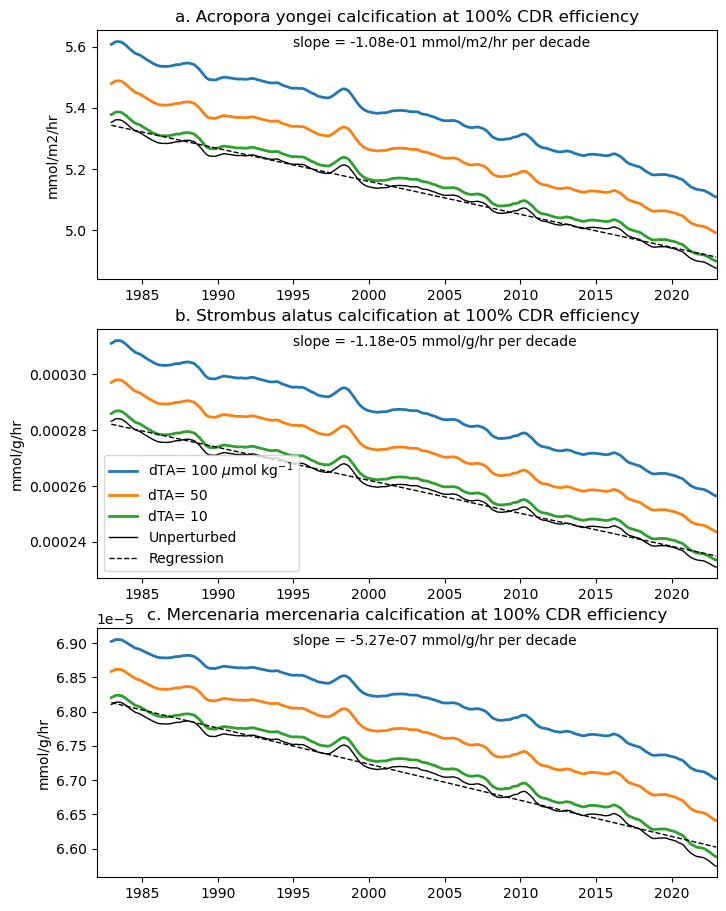

In [35]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplot_mosaic(
    '''
    A
    B
    C
    ''',
    figsize = (8, 11)
)
# alkstar to use as the xval for calcification regression predictions
alkstar0 = np.squeeze(ds_dict["alkstar_global_wmean_dTA0"]).copy()
alkstar1 = np.squeeze(ds_dict["alkstar_global_wmean_dTA10"]).copy()
alkstar2 = np.squeeze(ds_dict["alkstar_global_wmean_dTA50"]).copy()
alkstar3 = np.squeeze(ds_dict["alkstar_global_wmean_dTA100"]).copy()
# initialize mitigation time shift table
delta_treatment = np.full((3,3), np.nan) # % n_vars (3 species) x n_deltaTA (1,10,100)
slope_control = np.full((3), np.nan)	 # % n_vars (3 species) x 1
year_shift = np.full((3,3), np.nan)      # % n_vars (3 species) x n_deltaTA (1,10,100)
mean_control = np.full((3), np.nan)      # % n_vars (3 species) x 1
# - - -
# Plot at ['A']
# Acropora yongei - linear - mmol/m2/hr
x = np.squeeze(ds_dict["yearfrac"]).copy()
y0 = f_lin(param_acr,alkstar0)
y1 = f_lin(param_acr,alkstar1)
y2 = f_lin(param_acr,alkstar2)
y3 = f_lin(param_acr,alkstar3)
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
ax['A'].plot(x, y3, 
    label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y1, 
    label='dTA= 10', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y0, 
    label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
ax['A'].plot(x, y_pred, 
    label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['A'].set_ylabel('mmol/m2/hr')
# ax['A'].legend(loc='lower left')
ax['A'].set_title('a. Acropora yongei calcification at 100% CDR efficiency')
ax['A'].set_xlim(1982, 2023)
y_min, y_max = ax['A'].get_ylim()
y_pos = y_min + 0.95 * (y_max - y_min)
ax['A'].text(1995, y_pos, f'slope = {10*slope:.2e} mmol/m2/hr per decade',
        fontsize=10, color='black', ha='left', va='center')
# % save for output to xls
mean_control[0] = np.nanmean(y0);
delta_treatment[0,0] = np.nanmean(y1-y0);
delta_treatment[0,1] = np.nanmean(y2-y0);
delta_treatment[0,2] = np.nanmean(y3-y0);
slope_control[0] = slope*10;
year_shift[0,0] = np.nanmean(y1-y0) / slope;
year_shift[0,1] = np.nanmean(y2-y0) / slope;
year_shift[0,2] = np.nanmean(y3-y0) / slope;
# - - -
# Plot at ['B']
# Strombus alatus - linear - mmol/g/hr
x = np.squeeze(ds_dict["yearfrac"]).copy()
y0 = f_lin(param_str,alkstar0)
y1 = f_lin(param_str,alkstar1)
y2 = f_lin(param_str,alkstar2)
y3 = f_lin(param_str,alkstar3)
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
ax['B'].plot(x, y3, 
    label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y1, 
    label='dTA= 10', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y0, 
    label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
ax['B'].plot(x, y_pred, 
    label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['B'].set_ylabel('mmol/g/hr')
ax['B'].legend(loc='lower left')
ax['B'].set_title('b. Strombus alatus calcification at 100% CDR efficiency')
ax['B'].set_xlim(1982, 2023)
y_min, y_max = ax['B'].get_ylim()
y_pos = y_min + 0.95 * (y_max - y_min)
ax['B'].text(1995, y_pos, f'slope = {10*slope:.2e} mmol/g/hr per decade',
        fontsize=10, color='black', ha='left', va='center')
# % save for output to xls
mean_control[1] = np.nanmean(y0);
delta_treatment[1,0] = np.nanmean(y1-y0);
delta_treatment[1,1] = np.nanmean(y2-y0);
delta_treatment[1,2] = np.nanmean(y3-y0);
slope_control[1] = slope*10;
year_shift[1,0] = np.nanmean(y1-y0) / slope;
year_shift[1,1] = np.nanmean(y2-y0) / slope;
year_shift[1,2] = np.nanmean(y3-y0) / slope;
# - - -
# Plot at ['C']
# Mercenaria mercenaria - exponential - mmol/g/hr
x = np.squeeze(ds_dict["yearfrac"]).copy()
y0 = f_exp(param_mer,alkstar0)
y1 = f_exp(param_mer,alkstar1)
y2 = f_exp(param_mer,alkstar2)
y3 = f_exp(param_mer,alkstar3)
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
ax['C'].plot(x, y3, 
    label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y1, 
    label='dTA= 10', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y0, 
    label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
ax['C'].plot(x, y_pred, 
    label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['C'].set_ylabel(r'mmol/g/hr')
# ax['C'].legend(loc='lower left')
ax['C'].set_title(r'c. Mercenaria mercenaria calcification at 100% CDR efficiency')
ax['C'].set_xlim(1982, 2023);
y_min, y_max = ax['C'].get_ylim()
y_pos = y_min + 0.95 * (y_max - y_min)
ax['C'].text(1995, y_pos, f'slope = {10*slope:.2e} mmol/g/hr per decade',
        fontsize=10, color='black', ha='left', va='center')
# % save for output to xls
mean_control[2] = np.nanmean(y0);
delta_treatment[2,0] = np.nanmean(y1-y0);
delta_treatment[2,1] = np.nanmean(y2-y0);
delta_treatment[2,2] = np.nanmean(y3-y0);
slope_control[2] = slope*10;
year_shift[2,0] = np.nanmean(y1-y0) / slope;
year_shift[2,1] = np.nanmean(y2-y0) / slope;
year_shift[2,2] = np.nanmean(y3-y0) / slope;
# - - -

fig.savefig('Fig8_global_cdreff100_12mo_movmean_calcification_v20.png', format='png', dpi=300);

In [36]:
# mitigation time shift table
print('mean_control: \n',mean_control)      # % n_vars (3 species) x 1
print('slope_control: \n',slope_control)	 # % n_vars (3 species) x 1
print('delta_treatment: \n',delta_treatment) # % n_vars (3 species) x n_deltaTA (1,10,100)
print('year_shift: \n',year_shift)      # % n_vars (3 species) x n_deltaTA (1,10,100)

mean_control: 
 [5.12747521e+00 2.58518877e-04 6.70776816e-05]
slope_control: 
 [-1.07788332e-01 -1.17823574e-05 -5.27335999e-07]
delta_treatment: 
 [[2.42795826e-02 1.21837004e-01 2.44762976e-01]
 [2.65400399e-06 1.33180170e-05 2.67550693e-05]
 [1.17023613e-07 5.63705577e-07 1.07645019e-06]]
year_shift: 
 [[ -2.2525242  -11.3033574  -22.70774317]
 [ -2.25252379 -11.30335534 -22.70773903]
 [ -2.21914702 -10.68968495 -20.41298477]]


## Coastal 12-month moving averages

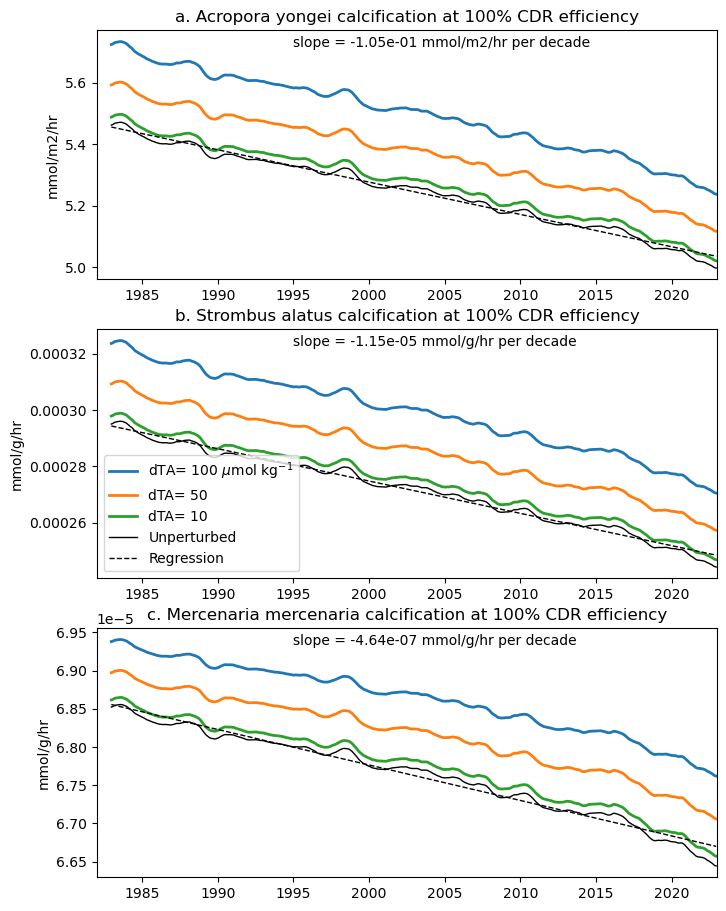

In [37]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplot_mosaic(
    '''
    A
    B
    C
    ''',
    figsize = (8, 11)
)
# alkstar to use as the xval for calcification regression predictions
alkstar0 = np.squeeze(ds_dict["alkstar_coastal_wmean_dTA0"]).copy()
alkstar1 = np.squeeze(ds_dict["alkstar_coastal_wmean_dTA10"]).copy()
alkstar2 = np.squeeze(ds_dict["alkstar_coastal_wmean_dTA50"]).copy()
alkstar3 = np.squeeze(ds_dict["alkstar_coastal_wmean_dTA100"]).copy()
# initialize mitigation time shift table
delta_treatment = np.full((3,3), np.nan) # % n_vars (3 species) x n_deltaTA (1,10,100)
slope_control = np.full((3), np.nan)	 # % n_vars (3 species) x 1
year_shift = np.full((3,3), np.nan)      # % n_vars (3 species) x n_deltaTA (1,10,100)
mean_control = np.full((3), np.nan)      # % n_vars (3 species) x 1
# - - -
# Plot at ['A']
# Acropora yongei - linear - mmol/m2/hr
x = np.squeeze(ds_dict["yearfrac"]).copy()
y0 = f_lin(param_acr,alkstar0)
y1 = f_lin(param_acr,alkstar1)
y2 = f_lin(param_acr,alkstar2)
y3 = f_lin(param_acr,alkstar3)
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
ax['A'].plot(x, y3, 
    label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y1, 
    label='dTA= 10', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y0, 
    label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
ax['A'].plot(x, y_pred, 
    label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['A'].set_ylabel('mmol/m2/hr')
# ax['A'].legend(loc='lower left')
ax['A'].set_title('a. Acropora yongei calcification at 100% CDR efficiency')
ax['A'].set_xlim(1982, 2023)
y_min, y_max = ax['A'].get_ylim()
y_pos = y_min + 0.95 * (y_max - y_min)
ax['A'].text(1995, y_pos, f'slope = {10*slope:.2e} mmol/m2/hr per decade',
        fontsize=10, color='black', ha='left', va='center')
# % save for output to xls
mean_control[0] = np.nanmean(y0);
delta_treatment[0,0] = np.nanmean(y1-y0);
delta_treatment[0,1] = np.nanmean(y2-y0);
delta_treatment[0,2] = np.nanmean(y3-y0);
slope_control[0] = slope*10;
year_shift[0,0] = np.nanmean(y1-y0) / slope;
year_shift[0,1] = np.nanmean(y2-y0) / slope;
year_shift[0,2] = np.nanmean(y3-y0) / slope;
# - - -
# Plot at ['B']
# Strombus alatus - linear - mmol/g/hr
x = np.squeeze(ds_dict["yearfrac"]).copy()
y0 = f_lin(param_str,alkstar0)
y1 = f_lin(param_str,alkstar1)
y2 = f_lin(param_str,alkstar2)
y3 = f_lin(param_str,alkstar3)
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
ax['B'].plot(x, y3, 
    label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y1, 
    label='dTA= 10', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y0, 
    label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
ax['B'].plot(x, y_pred, 
    label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['B'].set_ylabel('mmol/g/hr')
ax['B'].legend(loc='lower left')
ax['B'].set_title('b. Strombus alatus calcification at 100% CDR efficiency')
ax['B'].set_xlim(1982, 2023)
y_min, y_max = ax['B'].get_ylim()
y_pos = y_min + 0.95 * (y_max - y_min)
ax['B'].text(1995, y_pos, f'slope = {10*slope:.2e} mmol/g/hr per decade',
        fontsize=10, color='black', ha='left', va='center')
# % save for output to xls
mean_control[1] = np.nanmean(y0);
delta_treatment[1,0] = np.nanmean(y1-y0);
delta_treatment[1,1] = np.nanmean(y2-y0);
delta_treatment[1,2] = np.nanmean(y3-y0);
slope_control[1] = slope*10;
year_shift[1,0] = np.nanmean(y1-y0) / slope;
year_shift[1,1] = np.nanmean(y2-y0) / slope;
year_shift[1,2] = np.nanmean(y3-y0) / slope;
# - - -
# Plot at ['C']
# Mercenaria mercenaria - exponential - mmol/g/hr
x = np.squeeze(ds_dict["yearfrac"]).copy()
y0 = f_exp(param_mer,alkstar0)
y1 = f_exp(param_mer,alkstar1)
y2 = f_exp(param_mer,alkstar2)
y3 = f_exp(param_mer,alkstar3)
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
ax['C'].plot(x, y3, 
    label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y1, 
    label='dTA= 10', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y0, 
    label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
ax['C'].plot(x, y_pred, 
    label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['C'].set_ylabel(r'mmol/g/hr')
# ax['C'].legend(loc='lower left')
ax['C'].set_title(r'c. Mercenaria mercenaria calcification at 100% CDR efficiency')
ax['C'].set_xlim(1982, 2023);
y_min, y_max = ax['C'].get_ylim()
y_pos = y_min + 0.95 * (y_max - y_min)
ax['C'].text(1995, y_pos, f'slope = {10*slope:.2e} mmol/g/hr per decade',
        fontsize=10, color='black', ha='left', va='center')
# % save for output to xls
mean_control[2] = np.nanmean(y0);
delta_treatment[2,0] = np.nanmean(y1-y0);
delta_treatment[2,1] = np.nanmean(y2-y0);
delta_treatment[2,2] = np.nanmean(y3-y0);
slope_control[2] = slope*10;
year_shift[2,0] = np.nanmean(y1-y0) / slope;
year_shift[2,1] = np.nanmean(y2-y0) / slope;
year_shift[2,2] = np.nanmean(y3-y0) / slope;
# - - -

fig.savefig('Fig8_coastal_cdreff100_12mo_movmean_calcification_v20.png', format='png', dpi=300);

In [38]:
# mitigation time shift table
print('mean_control: \n',mean_control)      # % n_vars (3 species) x 1
print('slope_control: \n',slope_control)	 # % n_vars (3 species) x 1
print('delta_treatment: \n',delta_treatment) # % n_vars (3 species) x n_deltaTA (1,10,100)
print('year_shift: \n',year_shift)      # % n_vars (3 species) x n_deltaTA (1,10,100)

mean_control: 
 [5.24571209e+00 2.71443364e-04 6.76272193e-05]
slope_control: 
 [-1.04866564e-01 -1.14629756e-05 -4.64391690e-07]
delta_treatment: 
 [[2.49503736e-02 1.25195142e-01 2.51489627e-01]
 [2.72732823e-06 1.36850955e-05 2.74903604e-05]
 [1.08741477e-07 5.23192486e-07 9.97656208e-07]]
year_shift: 
 [[ -2.37924956 -11.93851813 -23.9818688 ]
 [ -2.37924978 -11.93851925 -23.98187105]
 [ -2.34158963 -11.26618968 -21.48307626]]


## Polar 12-month moving averages

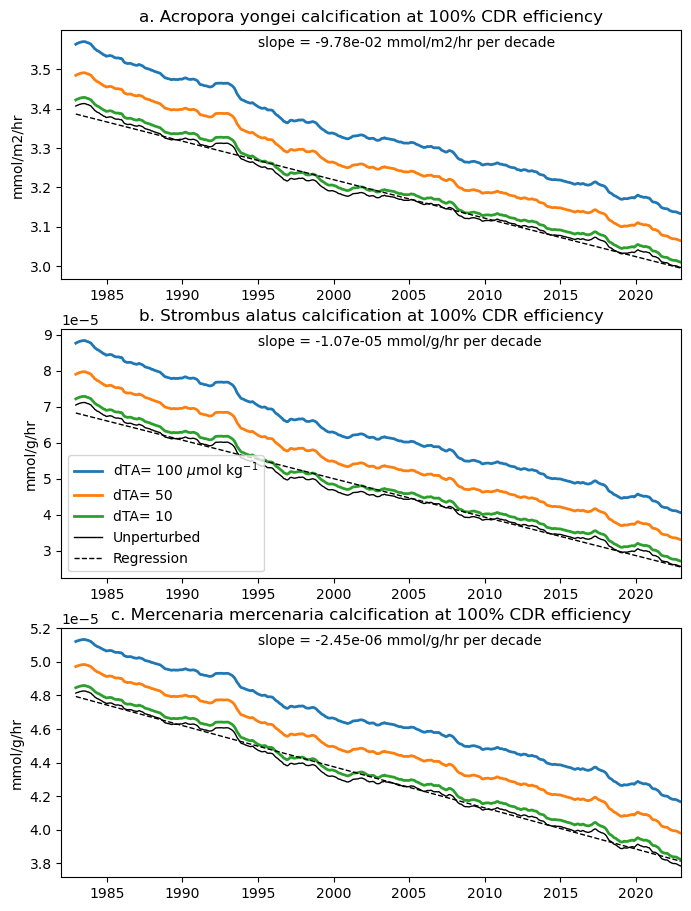

In [39]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplot_mosaic(
    '''
    A
    B
    C
    ''',
    figsize = (8, 11)
)
# alkstar to use as the xval for calcification regression predictions
alkstar0 = np.squeeze(ds_dict["alkstar_polar_wmean_dTA0"]).copy()
alkstar1 = np.squeeze(ds_dict["alkstar_polar_wmean_dTA10"]).copy()
alkstar2 = np.squeeze(ds_dict["alkstar_polar_wmean_dTA50"]).copy()
alkstar3 = np.squeeze(ds_dict["alkstar_polar_wmean_dTA100"]).copy()
# initialize mitigation time shift summary
delta_treatment = np.full((3,3), np.nan) # % n_vars (3 species) x n_deltaTA (1,10,100)
slope_control = np.full((3), np.nan)	 # % n_vars (3 species) x 1
year_shift = np.full((3,3), np.nan)      # % n_vars (3 species) x n_deltaTA (1,10,100)
mean_control = np.full((3), np.nan)      # % n_vars (3 species) x 1
# - - -
# Plot at ['A']
# Acropora yongei - linear - mmol/m2/hr
x = np.squeeze(ds_dict["yearfrac"]).copy()
y0 = f_lin(param_acr,alkstar0)
y1 = f_lin(param_acr,alkstar1)
y2 = f_lin(param_acr,alkstar2)
y3 = f_lin(param_acr,alkstar3)
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
ax['A'].plot(x, y3, 
    label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y1, 
    label='dTA= 10', linestyle='-', marker='', linewidth=2)
ax['A'].plot(x, y0, 
    label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
ax['A'].plot(x, y_pred, 
    label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['A'].set_ylabel('mmol/m2/hr')
# ax['A'].legend(loc='lower left')
ax['A'].set_title('a. Acropora yongei calcification at 100% CDR efficiency')
ax['A'].set_xlim(1982, 2023)
y_min, y_max = ax['A'].get_ylim()
y_pos = y_min + 0.95 * (y_max - y_min)
ax['A'].text(1995, y_pos, f'slope = {10*slope:.2e} mmol/m2/hr per decade',
        fontsize=10, color='black', ha='left', va='center')
# % save for output to xls
mean_control[0] = np.nanmean(y0);
delta_treatment[0,0] = np.nanmean(y1-y0);
delta_treatment[0,1] = np.nanmean(y2-y0);
delta_treatment[0,2] = np.nanmean(y3-y0);
slope_control[0] = slope*10;
year_shift[0,0] = np.nanmean(y1-y0) / slope;
year_shift[0,1] = np.nanmean(y2-y0) / slope;
year_shift[0,2] = np.nanmean(y3-y0) / slope;
# - - -
# Plot at ['B']
# Strombus alatus - linear - mmol/g/hr
x = np.squeeze(ds_dict["yearfrac"]).copy()
y0 = f_lin(param_str,alkstar0)
y1 = f_lin(param_str,alkstar1)
y2 = f_lin(param_str,alkstar2)
y3 = f_lin(param_str,alkstar3)
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
ax['B'].plot(x, y3, 
    label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y1, 
    label='dTA= 10', linestyle='-', marker='', linewidth=2)
ax['B'].plot(x, y0, 
    label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
ax['B'].plot(x, y_pred, 
    label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['B'].set_ylabel('mmol/g/hr')
ax['B'].legend(loc='lower left')
ax['B'].set_title('b. Strombus alatus calcification at 100% CDR efficiency')
ax['B'].set_xlim(1982, 2023)
y_min, y_max = ax['B'].get_ylim()
y_pos = y_min + 0.95 * (y_max - y_min)
ax['B'].text(1995, y_pos, f'slope = {10*slope:.2e} mmol/g/hr per decade',
        fontsize=10, color='black', ha='left', va='center')
# % save for output to xls
mean_control[1] = np.nanmean(y0);
delta_treatment[1,0] = np.nanmean(y1-y0);
delta_treatment[1,1] = np.nanmean(y2-y0);
delta_treatment[1,2] = np.nanmean(y3-y0);
slope_control[1] = slope*10;
year_shift[1,0] = np.nanmean(y1-y0) / slope;
year_shift[1,1] = np.nanmean(y2-y0) / slope;
year_shift[1,2] = np.nanmean(y3-y0) / slope;
# - - -
# Plot at ['C']
# Mercenaria mercenaria - exponential - mmol/g/hr
x = np.squeeze(ds_dict["yearfrac"]).copy()
y0 = f_exp(param_mer,alkstar0)
y1 = f_exp(param_mer,alkstar1)
y2 = f_exp(param_mer,alkstar2)
y3 = f_exp(param_mer,alkstar3)
n=12
x = x[(n-1):]
y0 = moving_average(y0,n)
y1 = moving_average(y1,n)
y2 = moving_average(y2,n)
y3 = moving_average(y3,n)
#
x_reshaped = x.reshape(-1, 1)
# Create and fit the model
model = LinearRegression()
model.fit(x_reshaped, y0)
# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_
# Generate predictions
y_pred = model.predict(x_reshaped)
#
ax['C'].plot(x, y3, 
    label=r'dTA= 100 $\mu$mol kg$^{-1}$', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y2, 
    label='dTA= 50', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y1, 
    label='dTA= 10', linestyle='-', marker='', linewidth=2)
ax['C'].plot(x, y0, 
    label='Unperturbed', linestyle='-', marker='', linewidth=1, color='k')
ax['C'].plot(x, y_pred, 
    label=f'Regression', linestyle='--', marker='', linewidth=1, color='k')
ax['C'].set_ylabel(r'mmol/g/hr')
# ax['C'].legend(loc='lower left')
ax['C'].set_title(r'c. Mercenaria mercenaria calcification at 100% CDR efficiency')
ax['C'].set_xlim(1982, 2023);
y_min, y_max = ax['C'].get_ylim()
y_pos = y_min + 0.95 * (y_max - y_min)
ax['C'].text(1995, y_pos, f'slope = {10*slope:.2e} mmol/g/hr per decade',
        fontsize=10, color='black', ha='left', va='center')
# % save for output to xls
mean_control[2] = np.nanmean(y0);
delta_treatment[2,0] = np.nanmean(y1-y0);
delta_treatment[2,1] = np.nanmean(y2-y0);
delta_treatment[2,2] = np.nanmean(y3-y0);
slope_control[2] = slope*10;
year_shift[2,0] = np.nanmean(y1-y0) / slope;
year_shift[2,1] = np.nanmean(y2-y0) / slope;
year_shift[2,2] = np.nanmean(y3-y0) / slope;
# - - -

fig.savefig('Fig8_polar_cdreff100_12mo_movmean_calcification_v20.png', format='png', dpi=300);

In [40]:
# mitigation time shift table
print('mean_control: \n',mean_control)      # % n_vars (3 species) x 1
print('slope_control: \n',slope_control)	 # % n_vars (3 species) x 1
print('delta_treatment: \n',delta_treatment) # % n_vars (3 species x n_deltaTA (1,10,100)
print('year_shift: \n',year_shift)      # % n_vars (3 species) x n_deltaTA (1,10,100)

mean_control: 
 [3.19087208e+00 4.68285635e-05 4.30272604e-05]
slope_control: 
 [-9.78057086e-02 -1.06911548e-05 -2.45293472e-06]
delta_treatment: 
 [[1.44885714e-02 7.27949037e-02 1.46465609e-01]
 [1.58374742e-06 7.95721936e-06 1.60101727e-05]
 [3.62289873e-07 1.77619188e-06 3.46581608e-06]]
year_shift: 
 [[ -1.48136255  -7.44280724 -14.97515955]
 [ -1.48136239  -7.44280641 -14.97515787]
 [ -1.47696496  -7.2410889  -14.12926309]]


# Extend the calcification analysis to all of the species

In [41]:
# how many rows and columns are in Hanna's Excel file for Table 1 species regression summary
df_nrows,df_ncols = df.shape
print('rows (species):',df_nrows,', columns: ',df_ncols)

rows (species): 27 , columns:  14


In [42]:
# initialize arrays of regression fit calcifcation time series

# predicted monthly time series of calcification
ds_dict["calcification_dTA0"] = np.full((df_nrows,NT), np.nan)
ds_dict["calcification_dTA10"] = np.full((df_nrows,NT), np.nan)
ds_dict["calcification_dTA50"] = np.full((df_nrows,NT), np.nan)
ds_dict["calcification_dTA100"] = np.full((df_nrows,NT), np.nan)

# regression fit of 12-month moving averages 
ds_dict["calcification_x_yearfrac"] = np.full((df_nrows,NT-11), np.nan) 
ds_dict["calcification_y0_fit"] = np.full((df_nrows,NT-11), np.nan) 
ds_dict["calcification_mean_control"] = np.full((df_nrows), np.nan)      
ds_dict["calcification_slope_control"] = np.full((df_nrows), np.nan)	 
ds_dict["calcification_delta_treatment"] = np.full((df_nrows,3), np.nan) 
ds_dict["calcification_year_shift"] = np.full((df_nrows,3), np.nan)     

In [43]:
# calcualate best-fit calcification time series for each species and mitigation time shift

tic()
from sklearn.linear_model import LinearRegression
print('Calculating best-fit calcification rates for each species, please wait...')
for i in range(df_nrows):
    if df['Response'][i] == 'linear':
        param = np.full(2, np.nan)
        param[0] = df['Intercept'][i]
        param[1] = df['Slope'][i]
        if df['Region'][i] == 'Deep':
            # global
            ds_dict["calcification_dTA0"][i,:] = f_lin(param,ds_dict["alkstar_global_wmean_dTA0"])       
            ds_dict["calcification_dTA10"][i,:] = f_lin(param,ds_dict["alkstar_global_wmean_dTA10"])       
            ds_dict["calcification_dTA50"][i,:] = f_lin(param,ds_dict["alkstar_global_wmean_dTA50"])       
            ds_dict["calcification_dTA100"][i,:] = f_lin(param,ds_dict["alkstar_global_wmean_dTA100"])       
        elif df['Region'][i] == 'Coastal':
            # coastal
            ds_dict["calcification_dTA0"][i,:] = f_lin(param,ds_dict["alkstar_coastal_wmean_dTA0"])       
            ds_dict["calcification_dTA10"][i,:] = f_lin(param,ds_dict["alkstar_coastal_wmean_dTA10"])       
            ds_dict["calcification_dTA50"][i,:] = f_lin(param,ds_dict["alkstar_coastal_wmean_dTA50"])       
            ds_dict["calcification_dTA100"][i,:] = f_lin(param,ds_dict["alkstar_coastal_wmean_dTA100"])       
        elif df['Region'][i] == 'Polar':
            # polar
            ds_dict["calcification_dTA0"][i,:] = f_lin(param,ds_dict["alkstar_polar_wmean_dTA0"])       
            ds_dict["calcification_dTA10"][i,:] = f_lin(param,ds_dict["alkstar_polar_wmean_dTA10"])       
            ds_dict["calcification_dTA50"][i,:] = f_lin(param,ds_dict["alkstar_polar_wmean_dTA50"])       
            ds_dict["calcification_dTA100"][i,:] = f_lin(param,ds_dict["alkstar_polar_wmean_dTA100"])       
    elif df['Response'][i] == 'exponential':
        param = np.full(3, np.nan)
        param[0] = df['Intercept'][i]
        param[1] = df['Slope'][i]
        param[2] = df['Exponent'][i]
        if df['Region'][i] == 'Deep':
            # global
            ds_dict["calcification_dTA0"][i,:] = f_exp(param,ds_dict["alkstar_global_wmean_dTA0"])       
            ds_dict["calcification_dTA10"][i,:] = f_exp(param,ds_dict["alkstar_global_wmean_dTA10"])       
            ds_dict["calcification_dTA50"][i,:] = f_exp(param,ds_dict["alkstar_global_wmean_dTA50"])       
            ds_dict["calcification_dTA100"][i,:] = f_exp(param,ds_dict["alkstar_global_wmean_dTA100"])       
        elif df['Region'][i] == 'Coastal':
            # coastal
            ds_dict["calcification_dTA0"][i,:] = f_exp(param,ds_dict["alkstar_coastal_wmean_dTA0"])       
            ds_dict["calcification_dTA10"][i,:] = f_exp(param,ds_dict["alkstar_coastal_wmean_dTA10"])       
            ds_dict["calcification_dTA50"][i,:] = f_exp(param,ds_dict["alkstar_coastal_wmean_dTA50"])       
            ds_dict["calcification_dTA100"][i,:] = f_exp(param,ds_dict["alkstar_coastal_wmean_dTA100"])       
        elif df['Region'][i] == 'Polar':
            # polar
            ds_dict["calcification_dTA0"][i,:] = f_exp(param,ds_dict["alkstar_polar_wmean_dTA0"])       
            ds_dict["calcification_dTA10"][i,:] = f_exp(param,ds_dict["alkstar_polar_wmean_dTA10"])       
            ds_dict["calcification_dTA50"][i,:] = f_exp(param,ds_dict["alkstar_polar_wmean_dTA50"])       
            ds_dict["calcification_dTA100"][i,:] = f_exp(param,ds_dict["alkstar_polar_wmean_dTA100"])       

    # time-series regressions of moving averges
    x = np.squeeze(ds_dict["yearfrac"]).copy()
    x = x[(n-1):]
    x_reshaped = x.reshape(-1, 1)
    n=12
    y0 = moving_average(ds_dict["calcification_dTA0"][i,:],n)
    y1 = moving_average(ds_dict["calcification_dTA10"][i,:],n)
    y2 = moving_average(ds_dict["calcification_dTA50"][i,:],n)
    y3 = moving_average(ds_dict["calcification_dTA100"][i,:],n)

    # Create and fit the model
    model = LinearRegression()
    model.fit(x_reshaped, y0)
    slope = model.coef_[0]
    intercept = model.intercept_
    ds_dict["calcification_x_yearfrac"][i,:] = x
    ds_dict["calcification_y0_fit"][i,:] = model.predict(x_reshaped)
    ds_dict["calcification_slope_control"][i] = slope*10;
    ds_dict["calcification_mean_control"][i] = np.nanmean(y0);
    ds_dict["calcification_delta_treatment"][i,0] = np.nanmean(y1-y0);
    ds_dict["calcification_delta_treatment"][i,1] = np.nanmean(y2-y0);
    ds_dict["calcification_delta_treatment"][i,2] = np.nanmean(y3-y0);
    ds_dict["calcification_year_shift"][i,0] = np.nanmean(y1-y0) / slope;
    ds_dict["calcification_year_shift"][i,1] = np.nanmean(y2-y0) / slope;
    ds_dict["calcification_year_shift"][i,2] = np.nanmean(y3-y0) / slope;

print('Done')
toc()    

Calculating best-fit calcification rates for each species, please wait...
Done
Elapsed time: 0.019813 seconds.



In [44]:
# put the summary of the regression results into the dataframe

# normalized slope relative to the mean of the control (percent change per decade)
df['RPD_slope'] = 100 * (ds_dict["calcification_slope_control"] / 
                         ds_dict["calcification_mean_control"])

# normalized mean change in calcification for each treatment relative to mean control (RPD) 
df['RPD_delta_dTA10'] = 100 * (ds_dict["calcification_delta_treatment"][:,0] /
                              ds_dict["calcification_mean_control"])
df['RPD_delta_dTA50'] = 100 * (ds_dict["calcification_delta_treatment"][:,1] /
                              ds_dict["calcification_mean_control"])
df['RPD_delta_dTA100'] = 100 * (ds_dict["calcification_delta_treatment"][:,2] /
                              ds_dict["calcification_mean_control"])

# mitigation time shift for each treatment (years) 
df['yearshift_dTA10'] = ds_dict["calcification_year_shift"][:,0]
df['yearshift_dTA50'] = ds_dict["calcification_year_shift"][:,1]
df['yearshift_dTA100'] = ds_dict["calcification_year_shift"][:,2]

In [45]:
# Save dataFrame with regression summary to Excel file with headers
df.to_excel('T1_calcification_response_to_OAE_at_CDReff100_v20.xlsx', index=False, header=True)